Import libraries

In [1]:
import xarray as xr
from PyCO2SYS import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import pandas as pd
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.io import loadmat
import warnings
warnings.filterwarnings("ignore")
import warnings

# 3rd party libraries
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec

from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import scipy
from glob import glob

In [2]:
file_dist = '/Users/zelun/Library/Application Support/MathWorks/MATLAB Add-Ons/Collections/Climate Data Toolbox for MATLAB/cdt/cdt_data/distance2coast.mat'
data_dist = loadmat(file_dist)

Define the lon lat boundaries and max min time

In [3]:
#%%
yr_min = 1993
time_min = np.datetime64('1993-01-01')
time_max = np.datetime64('2021-12-31')
lon_min = -170
lon_max = -40
lat_min = 10
lat_max = 65
#%%
def calc_clim_anom(ts):
    ts_reshape = np.reshape(ts,[np.int64(len(ts)/12),12])
    ts_detrend = scipy.signal.detrend(ts,axis=0)
    ts_detrend_reshape = np.reshape(ts_detrend,ts_reshape.shape)
    clim = np.nanmean(ts_detrend_reshape,axis=0)
    ts_anom = ts_reshape - clim
    ts_anom = np.reshape(ts_anom,ts.shape)
    return clim,ts_anom
n_yr = np.int64(2022-yr_min)

Define the function to calculate anomalies

In [4]:
def calc_clim_anom(ts):
    if np.isnan(ts).any():
        ts = pd.Series(ts)
        ts = ts.interpolate(method='linear')
    ts_reshape = np.reshape(ts,[np.int64(len(ts)/12),12])
    ts_detrend = scipy.signal.detrend(ts,axis=0)
    ts_detrend_reshape = np.reshape(ts_detrend,ts_reshape.shape)
    clim = np.nanmean(ts_detrend_reshape,axis=0)
    ts_anom = ts_reshape - clim
    clim = clim + np.nanmean(ts_anom)
    ts_anom = ts_anom - np.nanmean(ts_anom)
    ts_anom = np.reshape(ts_anom,ts.shape)
    return clim,ts_anom

def get_clim_anom(ts):
    ts_clim = np.nanmean(np.reshape(ts,(np.int64(len(ts)/12),12)),axis=0)
    ts_anom = np.reshape(ts,(np.int64(len(ts)/12),12)) - ts_clim
    ts_anom = np.reshape(ts_anom,ts.shape)
    return ts_clim, ts_anom

read SOCAT and product_coastal_v2 data

In [5]:
# file = '/Volumes/Crucial_4T/carbon/SOM_FNN/ULB-SOM-FFN-coastalv2.nc'
# ds_product = xr.open_dataset(file)
# lon_socat = ds_product.lon.values
# lat_socat = ds_product.lat.values
# time_product = ds_product.time.values
# idxt = np.where((time_product>=time_min))[0]
# idxx = np.where((lon_socat>=lon_min) & (lon_socat<=lon_max))[0]
# idxy = np.where((lat_socat>=lat_min) & (lat_socat<=lat_max))[0]
# lon_socat = lon_socat[idxx]
# lat_socat = lat_socat[idxy]
# time_product = time_product[idxt]
# # mask_400km = ds_product.pco2[idxt,idxy,idxx].values
# # mask_400km = np.nanmean(mask_400km,axis=0)/np.nanmean(mask_400km,axis=0)
# # plt.pcolor(lon_socat,lat_socat,mask)


In [5]:
file = 'data/fco2_est_4d2.mat'
data = loadmat(file)
fco2_product = data['fco2_est_4d'] 
fco2_product_4d = np.transpose(fco2_product,(3,2,1,0))
# fco2_product_clim = np.nanmean(fco2_product_4d,axis=0)

In [6]:
#%% SOCAT v2023
file_socat = '/Volumes/Crucial_4T/carbon/SOCAT/v2023/SOCATv2023_qrtrdeg_gridded_coast_monthly.nc'
# file_socat = '/Users/zelun/Library/CloudStorage/OneDrive-Personal/data/carbon/socat/SOCATv2023_qrtrdeg_gridded_coast_monthly.nc'
ds_socat = xr.open_dataset(file_socat)
lon_socat = ds_socat.xlon.values
lat_socat = ds_socat.ylat.values
time_socat = ds_socat.tmnth.values
idxx = np.where((lon_socat>=lon_min) & (lon_socat<=lon_max))[0]
idxy = np.where((lat_socat>=lat_min) & (lat_socat<=lat_max))[0]
idxt = np.where((time_socat>=time_min) & (time_socat<=time_max))[0]
lon_socat = lon_socat[idxx]
lat_socat = lat_socat[idxy]
time_socat = time_socat[idxt]
fco2_socat = ds_socat.coast_fco2_ave_weighted[idxt,idxy,idxx].values
sst_socat = ds_socat.coast_sst_ave_weighted[idxt,idxy,idxx].values
sss_socat = ds_socat.coast_salinity_ave_weighted[idxt,idxy,idxx].values
fco2_socat[(fco2_socat>1000)|(fco2_socat<1)] = np.nan
sst_socat[(sst_socat>100)|(sst_socat<-4)] = np.nan
sss_socat[(sss_socat>100)|(sss_socat<0)] = np.nan
fco2_socat_4d = np.reshape(fco2_socat,(np.int64(sst_socat.shape[0]/12),12,sst_socat.shape[1],sst_socat.shape[2]))
sst_socat_4d = np.reshape(sst_socat,(np.int64(sst_socat.shape[0]/12),12,sst_socat.shape[1],sst_socat.shape[2]))
sss_socat_4d = np.reshape(sss_socat,(np.int64(sss_socat.shape[0]/12),12,sss_socat.shape[1],sss_socat.shape[2]))

fco2_socat[(fco2_socat>1000)|(fco2_socat<1)] = np.nan
fco2_socat[fco2_socat<=np.nanmean(fco2_socat)-3*np.nanstd(fco2_socat)] = np.nan
fco2_socat[fco2_socat>=np.nanmean(fco2_socat)+3*np.nanstd(fco2_socat)] = np.nan

fco2_socat_clim = np.nanmean(fco2_socat_4d,axis=0)


In [7]:
#%%
file_soda = '/Volumes/Crucial_4T/Model/soda/3.15.2/soda3.15.2_mn_ocean_reg_'+str(yr_min)+'.nc'
ds_soda = xr.open_dataset(file_soda)
lon_soda = ds_soda.xt_ocean.values
lat_soda = ds_soda.yt_ocean.values
sss_4d = np.full((n_yr,12,len(lat_socat),len(lon_socat)),np.nan)

for yr in range(yr_min,2021):
    file_soda = '/Volumes/Crucial_4T/Model/soda/3.15.2/soda3.15.2_mn_ocean_reg_'+str(yr)+'.nc'
    ds_soda = xr.open_dataset(file_soda)
    sss_4d[yr-yr_min] = ds_soda.salt[:,0,:,:].interp(yt_ocean=lat_socat,xt_ocean=lon_socat+360).values
sss_3d = sss_4d.reshape(fco2_socat.shape)
#%% SST
file_sst = '/Volumes/Crucial_4T/SST/OISST_v2.1/oisst-avhrr-v02r01.19810901.nc'
ds_sst = xr.open_dataset(file_sst)
lon_sst = ds_sst.lon.values
lat_sst = ds_sst.lat.values
idxlon = np.where((lon_sst>=lon_min+360)&(lon_sst<=lon_max+360))[0]
idxlat = np.where((lat_sst>=lat_min)&(lat_sst<=lat_max))[0]
sst_oisst_4d = np.full((n_yr,12,len(lat_socat),len(lon_socat)),np.nan)
for yr in range(yr_min,2021):
    for mon in range(1,13):
        idxt = np.int64((yr-yr_min)*12+mon-1)
        files_sst = glob('/Volumes/Crucial_4T/SST/OISST_v2.1/oisst-avhrr-v02r01.'+str(yr)+str(mon).zfill(2)+'*.nc')
        sst_i = np.full((len(files_sst),len(idxlat),len(idxlon)),np.nan)
        for idxf in range(len(files_sst)):
            file_sst = files_sst[idxf]
            ds_sst = xr.open_dataset(file_sst)
            sst_i[idxf] = ds_sst.sst[:,:,idxlat,idxlon].values
        sst_oisst_4d[yr-yr_min,mon-1] = np.nanmean(sst_i,axis=0)
sst_oisst_3d = sst_oisst_4d.reshape(fco2_socat.shape)

Generate mask of each subregions

In [10]:
lat_msh, lon_msh = np.meshgrid(lat_socat,lon_socat,indexing='ij')

ds_dist = xr.open_dataset('/Users/zelun/Library/CloudStorage/OneDrive-Personal/data/dist2coast.nc')
dist2coast = ds_dist.D.interp(lon=lon_socat,lat=lat_socat).values

file_topo = '/Volumes/Crucial_4T/etopo/ETOPO2/ETOPO2v2c_f4.nc'
ds_topo = xr.open_dataset(file_topo)
depth = ds_topo.z.interp(x=lon_socat,y=lat_socat).values

dist2coast[depth>0] = np.nan
dist2coast[dist2coast>400] = np.nan

# plt.pcolor(lon_socat,lat_socat,dist2coast)

dist2coast_3d = np.repeat(dist2coast.reshape(1,len(lat_socat),len(lon_socat)),repeats=fco2_socat.shape[0],axis=0)


mask = dict({})
# mask['mask_AL'] = np.float64((lon_msh>=-160)&(lon_msh<=-150)&(lat_msh>=50)&(lat_msh<=60))
mask['mask_AL'] = np.float64((lon_msh>=-160)&(lon_msh<=-100)&(lat_msh>=50)&(lat_msh<=60))
mask['mask_AL'][mask['mask_AL']<0.5] = np.nan
mask['mask_AL'] = np.repeat(np.reshape(mask['mask_AL'],(1,len(lat_socat),len(lon_socat))),len(time_socat),axis=0)
mask['mask_AL'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_NCCS'] = np.float64((lon_msh>=-130)&(lon_msh<=-120)&(lat_msh>=42)&(lat_msh<=50))
mask['mask_NCCS'][mask['mask_NCCS']<0.5] = np.nan
mask['mask_NCCS'] = np.repeat(np.reshape(mask['mask_NCCS'],(1,len(lat_socat),len(lon_socat))),len(time_socat),axis=0)
mask['mask_NCCS'][np.isnan(dist2coast_3d)] = np.nan

# mask['mask_NCCS = np.float64((lon_msh>=-130)&(lon_msh<=-120)&(lat_msh>=38)&(lat_msh<=42))
# mask['mask_NCCS[mask['mask_NCCS<0.5] = np.nan
# mask['mask_NCCS = np.repeat(np.reshape(mask['mask_NCCS,(1,len(lat_socat),len(lon_socat))),len(time_socat),axis=0)

mask['mask_CCCS'] = np.float64((lon_msh>=-130)&(lon_msh<=-110)&(lat_msh>=30)&(lat_msh<=42))
mask['mask_CCCS'][mask['mask_CCCS']<0.5] = np.nan
mask['mask_CCCS'] = np.repeat(np.reshape(mask['mask_CCCS'],(1,len(lat_socat),len(lon_socat))),len(time_socat),axis=0)
mask['mask_CCCS'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_SCCS'] = np.float64((lon_msh>=-130)&(lon_msh<=-100)&(lat_msh>=20)&(lat_msh<=30))
mask['mask_SCCS'][mask['mask_SCCS']<0.5] = np.nan
mask['mask_SCCS'] = np.repeat(np.reshape(mask['mask_SCCS'],(1,len(lat_socat),len(lon_socat))),len(time_socat),axis=0)
mask['mask_SCCS'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_GoMeSS'] = np.float64((lon_msh>-70)&(lon_msh<=-60)&(lat_msh>=41.5)&(lat_msh<=46))
mask['mask_GoMeSS'][mask['mask_GoMeSS']<0.5] = np.nan
mask['mask_GoMeSS'] = np.repeat(np.reshape(mask['mask_GoMeSS'],(1,len(lat_socat),len(lon_socat))),len(time_socat),axis=0)
mask['mask_GoMeSS'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_GoMe'] = np.float64((lon_msh>-71)&(lon_msh<=-65.5)&(lat_msh>=41.5)&(lat_msh<=46))
mask['mask_GoMe'][mask['mask_GoMe']<0.5] = np.nan
mask['mask_GoMe'] = np.repeat(np.reshape(mask['mask_GoMe'],(1,len(lat_socat),len(lon_socat))),len(time_socat),axis=0)
mask['mask_GoMe'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_SS'] = np.float64((lon_msh>-65.5)&(lon_msh<=-60)&(lat_msh>=37)&(lat_msh<=46))
mask['mask_SS'][mask['mask_SS']<0.5] = np.nan
mask['mask_SS'] = np.repeat(np.reshape(mask['mask_SS'],(1,len(lat_socat),len(lon_socat))),len(time_socat),axis=0)
mask['mask_SS'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_GStL'] = np.float64((lon_msh>-69)&(lon_msh<=-45)&(lat_msh>=41.5)&(lat_msh<=51))
mask['mask_GStL'][mask['mask_GStL']<0.5] = np.nan
mask['mask_GStL'] = np.repeat(np.reshape(mask['mask_GStL'],(1,len(lat_socat),len(lon_socat))),len(time_socat),axis=0)
mask['mask_GStL'][mask['mask_GoMeSS']>0.5] = np.nan
mask['mask_GStL'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_SAB'] = np.float64((lon_msh>=-82)&(lon_msh<=-70)&(lat_msh>=27)&(lat_msh<=35.5))
mask['mask_SAB'][mask['mask_SAB']<0.5] = np.nan
mask['mask_SAB'] = np.repeat(np.reshape(mask['mask_SAB'],(1,len(lat_socat),len(lon_socat))),len(time_socat),axis=0)
mask['mask_SAB'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_MAB'] = np.float64((lon_msh>=-82)&(lon_msh<=-60)&(lat_msh>=35.5)&(lat_msh<=41.5))
mask['mask_MAB'][mask['mask_MAB']<0.5] = np.nan
mask['mask_MAB'] = np.repeat(np.reshape(mask['mask_MAB'],(1,len(lat_socat),len(lon_socat))),len(time_socat),axis=0)
mask['mask_MAB'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_GoMx'] = np.float64((lon_msh>=-100)&(lon_msh<=-80)&(lat_msh>=17)&(lat_msh<=31))
mask['mask_GoMx'][mask['mask_GoMx']<0.5] = np.nan
x1 = -83; y1 = 31; x2 = -81; y2 =25.5
a = (y2-y1)/(x2-x1)
b = y2-a*x2
mask['mask_GoMx'][(a*lon_msh+b)<lat_msh] = np.nan
x1 = -87.0; y1 = 21; x2 = -80.5; y2 =25
a = (y2-y1)/(x2-x1)
b = y2-a*x2
mask['mask_GoMx'][(a*lon_msh+b)>lat_msh] = np.nan
mask['mask_GoMx'][(lon_msh<=-89.75) & (lat_msh>=29.5)] = np.nan
mask['mask_GoMx'] = np.repeat(np.reshape(mask['mask_GoMx'],(1,len(lat_socat),len(lon_socat))),len(time_socat),axis=0)
mask['mask_GoMx'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_CbS'] = np.float64((lon_msh>=-90)&(lon_msh<=-55)&(lat_msh>=15)&(lat_msh<=27))
mask['mask_CbS'][mask['mask_CbS']<0.5] = np.nan
mask['mask_CbS'] = np.repeat(np.reshape(mask['mask_CbS'],(1,len(lat_socat),len(lon_socat))),len(time_socat),axis=0)
mask['mask_CbS'][~np.isnan(mask['mask_GoMx'])] = np.nan
mask['mask_CbS'][~np.isnan(mask['mask_SAB'])] = np.nan
mask['mask_CbS'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_Isth'] = np.float64((lon_msh>=-130)&(lon_msh<=-98)&(lat_msh>=13)&(lat_msh<=20))
mask['mask_Isth'][mask['mask_Isth']<0.5] = np.nan
mask['mask_Isth'] = np.repeat(np.reshape(mask['mask_Isth'],(1,len(lat_socat),len(lon_socat))),len(time_socat),axis=0)
mask['mask_Isth'][mask['mask_GoMx']>0.5] = np.nan
mask['mask_Isth'][mask['mask_CbS']>0.5] = np.nan
mask['mask_Isth'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_Pacific'] = np.float64((~np.isnan(mask['mask_NCCS']) + ~np.isnan(mask['mask_CCCS']) + ~np.isnan(mask['mask_SCCS'])+ ~np.isnan(mask['mask_Isth']))>0)
mask['mask_Pacific'][mask['mask_Pacific']<0.5] = np.nan
mask['mask_Pacific'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_Atlantic'] = np.float64((~np.isnan(mask['mask_SAB']) + ~np.isnan(mask['mask_MAB']) + ~np.isnan(mask['mask_SS']) + ~np.isnan(mask['mask_GStL']))>0)
mask['mask_Atlantic'][mask['mask_Atlantic']<0.5] = np.nan
mask['mask_Atlantic'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_GoMxCbS'] = np.float64((~np.isnan(mask['mask_GoMx']) + ~np.isnan(mask['mask_CbS']))>0)
mask['mask_GoMxCbS'][mask['mask_GoMxCbS']<0.5] = np.nan
mask['mask_GoMxCbS'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_NAC'] = np.float64((~np.isnan(mask['mask_Pacific']) + ~np.isnan(mask['mask_Atlantic']) + ~np.isnan(mask['mask_GoMe'])+ ~np.isnan(mask['mask_GoMxCbS']))>0)
mask['mask_NAC'][mask['mask_NAC']<0.5] = np.nan
mask['mask_NAC'][np.isnan(dist2coast_3d)] = np.nan

mask['mask_NAC2'] = np.float64((~np.isnan(mask['mask_Pacific']) + ~np.isnan(mask['mask_Atlantic']) + ~np.isnan(mask['mask_AL']) + ~np.isnan(mask['mask_GoMe'])+ ~np.isnan(mask['mask_GoMxCbS']))>0)
mask['mask_NAC2'][mask['mask_NAC2']<0.5] = np.nan
mask['mask_NAC2'][np.isnan(dist2coast_3d)] = np.nan

In [16]:
lat_msh, lon_msh = np.meshgrid(lat_socat,lon_socat,indexing='ij')
mask['mask_Atlantic_forinterp'] = np.double(~np.isnan(np.nanmean(dist2coast_3d,axis=0)))
mask['mask_Atlantic_forinterp'][mask['mask_Atlantic_forinterp']<0.5] = np.nan
mask['mask_Atlantic_forinterp'][lon_msh<-100] = np.nan
mask['mask_Atlantic_forinterp'][(lon_msh<-90) & (lat_msh<17)] = np.nan
mask['mask_Atlantic_forinterp'][(lon_msh<-83.75) & (lat_msh<15)] = np.nan

mask['mask_Pacific_forinterp'] = np.double(~np.isnan(np.nanmean(dist2coast_3d,axis=0)))
mask['mask_Pacific_forinterp'][mask['mask_Pacific_forinterp']<0.5] = np.nan
mask['mask_Pacific_forinterp'][~np.isnan(mask['mask_Atlantic_forinterp'])] = np.nan

mask['mask_Atlantic_forinterp'] = np.repeat(np.reshape(mask['mask_Atlantic_forinterp'],(1,len(lat_socat),len(lon_socat))),repeats=12,axis=0)
mask['mask_Pacific_forinterp'] = np.repeat(np.reshape(mask['mask_Pacific_forinterp'],(1,len(lat_socat),len(lon_socat))),repeats=12,axis=0)
# plt.pcolor(lon_socat,lat_socat,mask['mask_Atlantic_forinterp'][0])

In [13]:
fco2_product_4d = np.transpose(fco2_product,(3,2,1,0)) * mask['mask_Atlantic_forinterp'][0]
fco2_product_clim = np.nanmean(fco2_product_4d,axis=0)
fco2_product = fco2_product_4d.reshape(fco2_socat.shape)

idx_out_train_4d = np.transpose(data['idxout_train'],(3,2,1,0))* mask['mask_Atlantic_forinterp'][0]
idx_out_test_4d = np.transpose(data['idxout_test'],(3,2,1,0))* mask['mask_Atlantic_forinterp'][0]
idx_out_validation_4d = np.transpose(data['idxout_validation'],(3,2,1,0))* mask['mask_Atlantic_forinterp'][0]

idx_out_train = idx_out_train_4d.reshape(fco2_product.shape)
idx_out_test = idx_out_test_4d.reshape(fco2_product.shape)
idx_out_validation = idx_out_validation_4d.reshape(fco2_product.shape)

In [14]:
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))

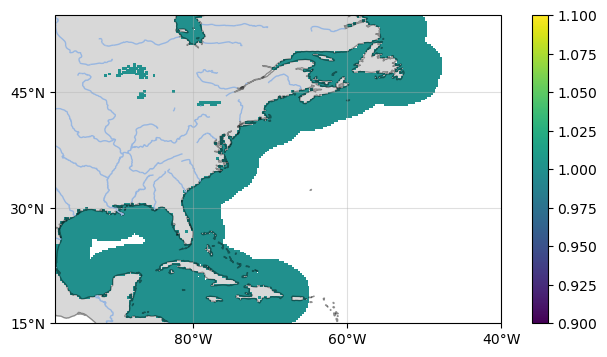

In [15]:
plt.figure(figsize=(8,4))
ax = plt.subplot(111,projection=projection)
ax.coastlines(alpha=0.4)
ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
ax.add_feature(cfeature.RIVERS)
ax.set_xticks(np.arange(-180,181, 20), crs=projection)
ax.set_yticks(np.arange(15,66, 15), crs=projection)
ax.grid('on',alpha=0.4)
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlim([-98,-40])
ax.set_ylim([15,55])
# plt.pcolor(lon_socat,lat_socat,mask['mask_Pacific_forinterp'])
plt.pcolor(lon_socat,lat_socat,mask['mask_Atlantic_forinterp'][0])
plt.colorbar()

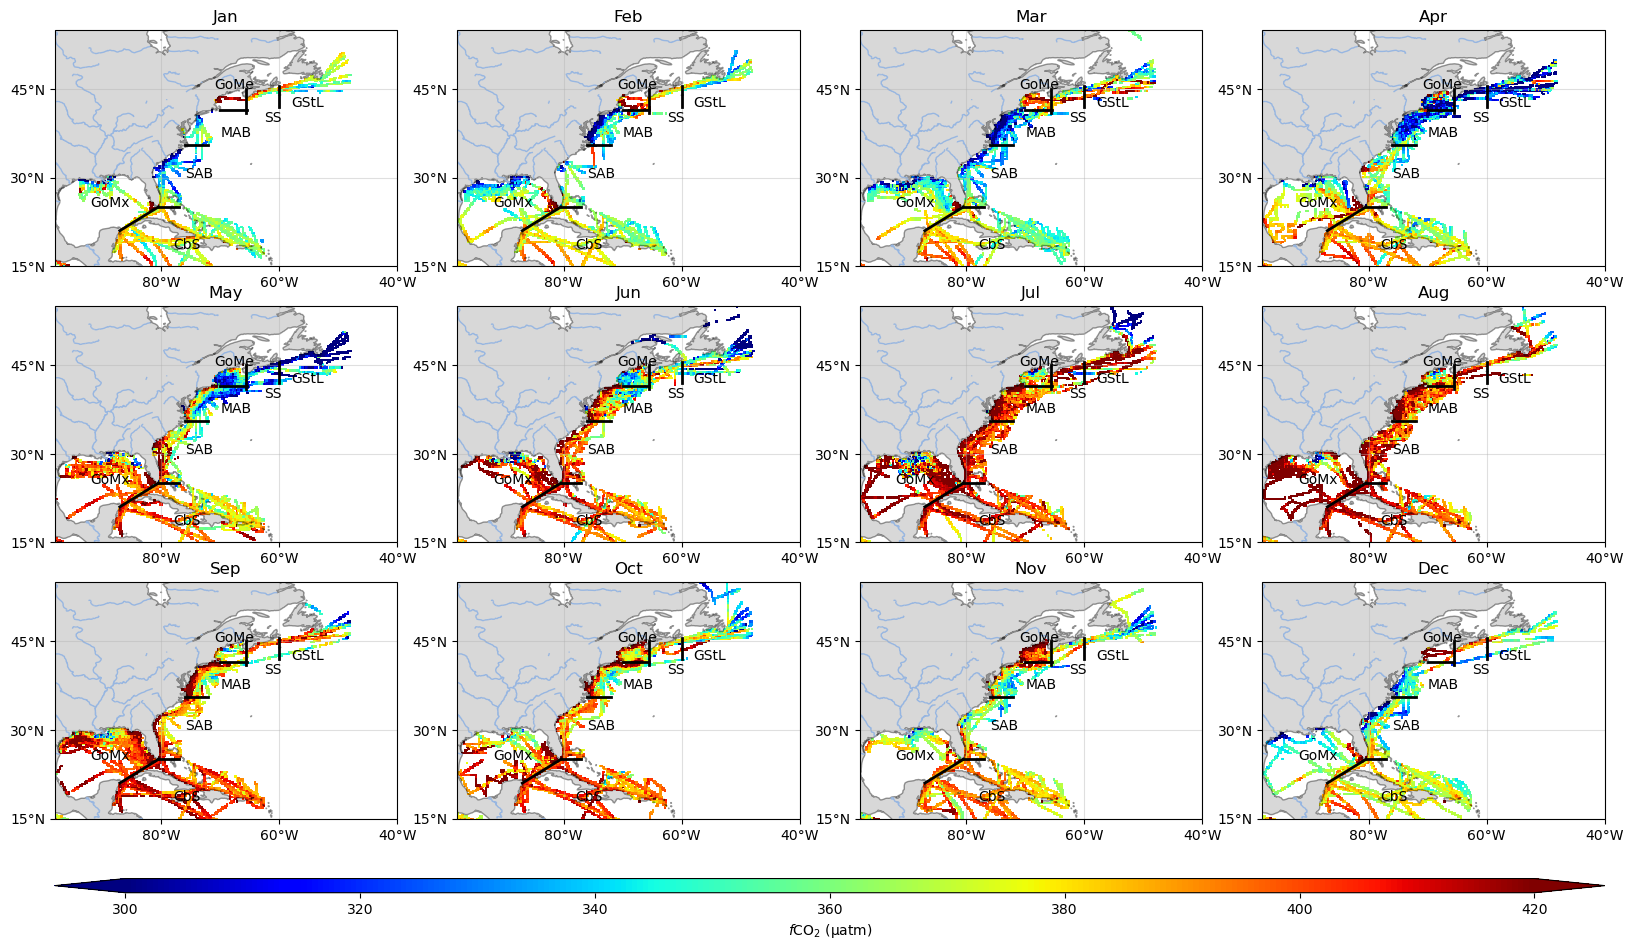

In [17]:
month_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig = plt.figure(figsize=(20,20))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3,4),
                axes_pad=(0.6,0.4),
                cbar_location='bottom',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='1.5%',
                label_mode='')  # note the empty label_mode
for idx, ax in enumerate(axgr):
    # ax = fig.add_subplot(4,3,idx+1)
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 20), crs=projection)
    ax.set_yticks(np.arange(15,66, 15), crs=projection)
    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-98,-40])
    ax.set_ylim([15,55])

    # boundary
    ax.plot([-80.5,-87],[25,21],c='k',linewidth=2) # GoMx & CbS
    ax.plot([-80.5,-77],[25,25],c='k',linewidth=2) # CbS & SAB
    ax.plot([-76,-72],[35.5,35.5],c='k',linewidth=2) # SAB & MAB
    ax.plot([-70,-65.5],[41.5,41.5],c='k',linewidth=2) # MAB & SS
    ax.plot([-65.6,-65.6],[41,45],c='k',linewidth=2) # SS & GoMe
    ax.plot([-60,-60],[42,45.5],c='k',linewidth=2) # SS & GStL

    # ax.plot([-135,-128.9],[50,50],c='k',linewidth=2) # NCCS & AL
    # ax.plot([-124.5,-128.9],[42,42],c='k',linewidth=2) # NCCS & CCCS
    # ax.plot([-120,-113],[30,30],c='k',linewidth=2) # CCCS & SCCS
    # ax.plot([-110,-105],[20,20],c='k',linewidth=2) # SCCS & Isth
    # names
    # ax.text(-150,50,'AL') 
    ax.text(-58,42,'GStL') 
    ax.text(-62.5,39.5,'SS') 
    ax.text(-71,45,'GoMe') 
    ax.text(-70,37,'MAB') 
    ax.text(-76,30,'SAB') 
    ax.text(-92,25,'GoMx') 
    ax.text(-78,18,'CbS') 

    # ax.text(-134,45,'NCCS') 
    # ax.text(-129,33,'CCCS') 
    # ax.text(-119,22,'SCCS') 
    # ax.text(-105,14,'Isth') 

    p0 = ax.pcolor(lon_socat,lat_socat,fco2_socat_clim[idx], transform=projection,cmap='jet',clim=[300,420])
    ax.set_title(month_str[idx])
cb1 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='${f}$CO$_2$ (µatm)')

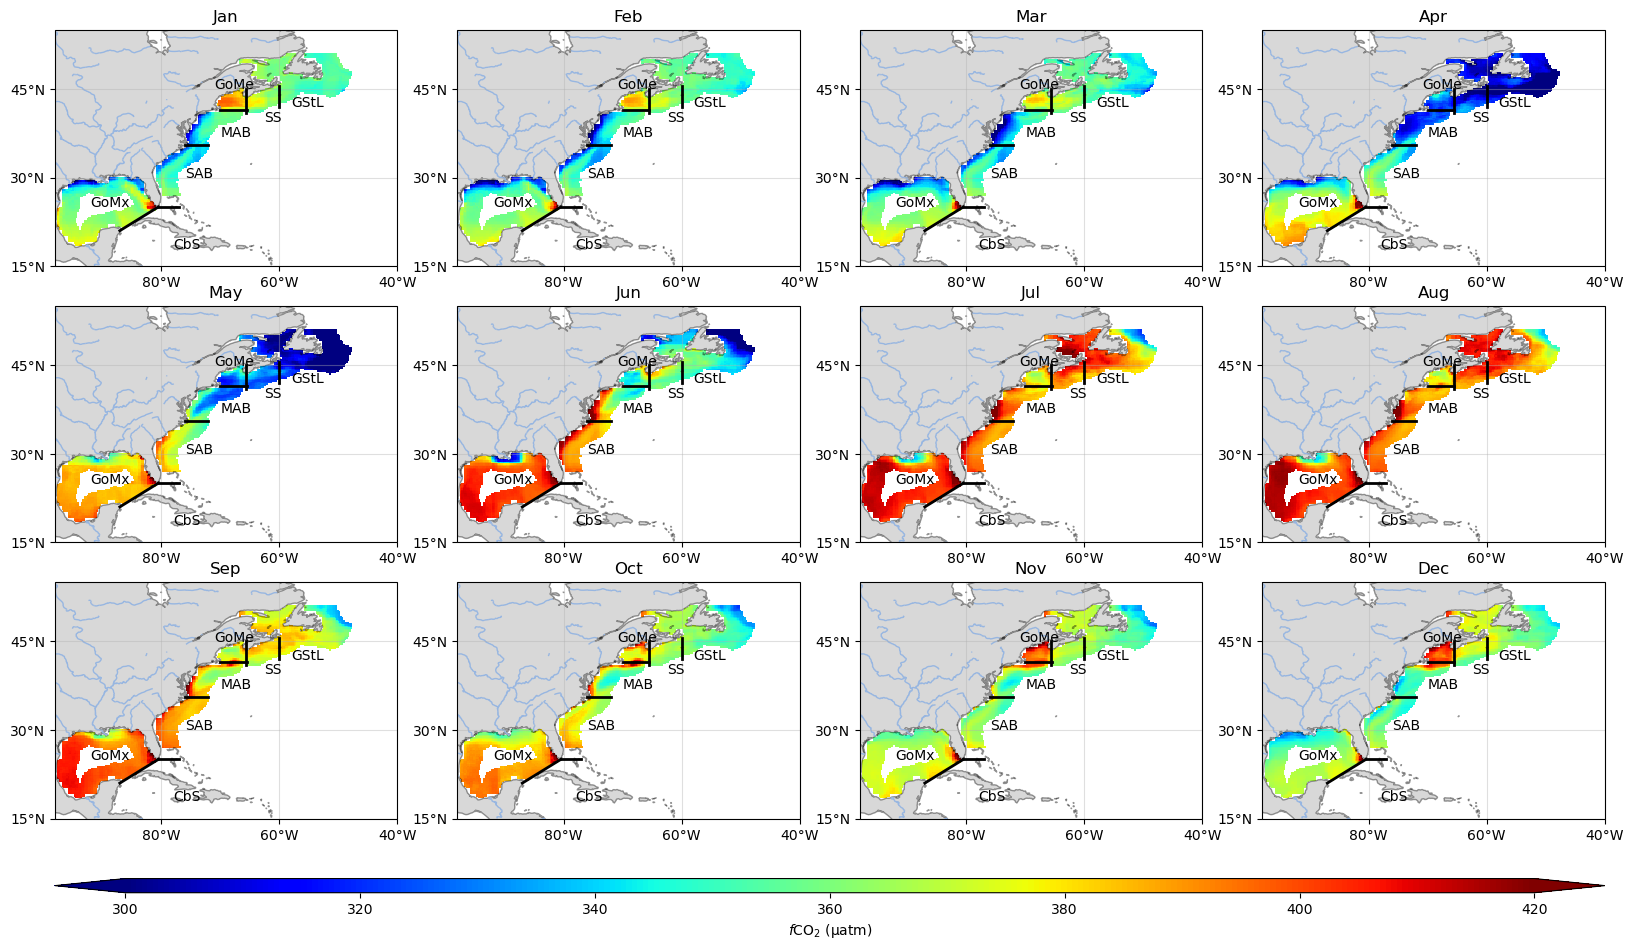

In [18]:
month_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig = plt.figure(figsize=(20,20))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3,4),
                axes_pad=(0.6,0.4),
                cbar_location='bottom',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='1.5%',
                label_mode='')  # note the empty label_mode
for idx, ax in enumerate(axgr):
    # ax = fig.add_subplot(4,3,idx+1)
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 20), crs=projection)
    ax.set_yticks(np.arange(15,66, 15), crs=projection)
    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-98,-40])
    ax.set_ylim([15,55])

    # boundary
    ax.plot([-80.5,-87],[25,21],c='k',linewidth=2) # GoMx & CbS
    ax.plot([-80.5,-77],[25,25],c='k',linewidth=2) # CbS & SAB
    ax.plot([-76,-72],[35.5,35.5],c='k',linewidth=2) # SAB & MAB
    ax.plot([-70,-65.5],[41.5,41.5],c='k',linewidth=2) # MAB & SS
    ax.plot([-65.6,-65.6],[41,45],c='k',linewidth=2) # SS & GoMe
    ax.plot([-60,-60],[42,45.5],c='k',linewidth=2) # SS & GStL

    # ax.plot([-135,-128.9],[50,50],c='k',linewidth=2) # NCCS & AL
    # ax.plot([-124.5,-128.9],[42,42],c='k',linewidth=2) # NCCS & CCCS
    # ax.plot([-120,-113],[30,30],c='k',linewidth=2) # CCCS & SCCS
    # ax.plot([-110,-105],[20,20],c='k',linewidth=2) # SCCS & Isth
    # names
    # ax.text(-150,50,'AL') 
    ax.text(-58,42,'GStL') 
    ax.text(-62.5,39.5,'SS') 
    ax.text(-71,45,'GoMe') 
    ax.text(-70,37,'MAB') 
    ax.text(-76,30,'SAB') 
    ax.text(-92,25,'GoMx') 
    ax.text(-78,18,'CbS') 

    # ax.text(-134,45,'NCCS') 
    # ax.text(-129,33,'CCCS') 
    # ax.text(-119,22,'SCCS') 
    # ax.text(-105,14,'Isth') 

    p0 = ax.pcolor(lon_socat,lat_socat,fco2_product_clim[idx], transform=projection,cmap='jet',clim=[300,420])
    ax.set_title(month_str[idx])
cb1 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='${f}$CO$_2$ (µatm)')

Compare the difference between product and SOCAT

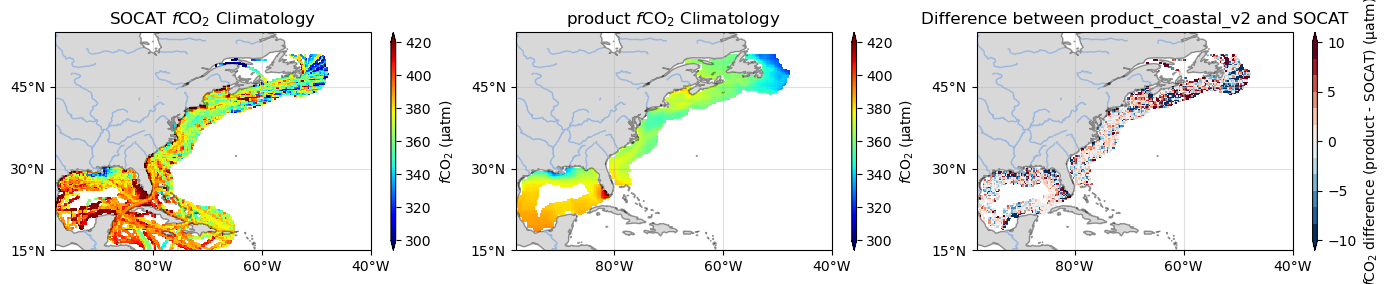

In [20]:
diff_obs_est = fco2_product - fco2_socat

fig = plt.figure(figsize=(14,4))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1,3),
                axes_pad=(1.2,0.7),
                cbar_location='right',
                cbar_mode='each',
                cbar_pad=0.2,
                cbar_size='1.5%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 20), crs=projection)
    ax.set_yticks(np.arange(15,66, 15), crs=projection)
    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-98,-40])
    ax.set_ylim([15,55])


    if i == 0:
        p0 = ax.pcolor(lon_socat,lat_socat,np.nanmean(fco2_socat_clim,axis=0)*mask['mask_NAC2'][0], transform=projection,cmap='jet',clim=[300,420])
        # ax.text(-165,66,'a',fontdict={'weight':'bold','size':15})
        ax.set_title('SOCAT ${f}$CO$_2$ Climatology')
    if i == 1:
        p1 = ax.pcolor(lon_socat,lat_socat,np.nanmean(fco2_product,axis=0)*mask['mask_NAC2'][0], transform=projection,cmap='jet',clim=[300,420])
        # ax.text(-165,66,'b',fontdict={'weight':'bold','size':15})
        ax.set_title('product ${f}$CO$_2$ Climatology')
    if i == 2:
        p2 = ax.pcolor(lon_socat,lat_socat,np.nanmean(diff_obs_est,axis=0)*mask['mask_NAC2'][0], transform=projection,cmap=plt.get_cmap('RdBu_r',12),clim=[-10,10])
        # ax.text(-165,66,'c',fontdict={'weight':'bold','size':15})
        ax.set_title('Difference between product_coastal_v2 and SOCAT')
cb1 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='${f}$CO$_2$ (µatm)')
cb1 = axgr.cbar_axes[1].colorbar(p1,extend='both',label='${f}$CO$_2$ (µatm)')
cb1 = axgr.cbar_axes[2].colorbar(p2,extend='both',label='${f}$CO$_2$ difference (product - SOCAT) (µatm)')
plt.tight_layout()
# plt.savefig('figs/SI01_01.jpg',dpi=600)
plt.show()

In [21]:
def bin_counts(x,y,xlim,ylim,step):
    x_new = np.arange(xlim[0],xlim[1]+step/2,step)
    y_new = np.arange(ylim[0],ylim[1]+step/2,step)

    dens = np.full((len(y_new),len(x_new)),np.nan)
    for idxx in range(len(x_new)):
        for idxy in range(len(y_new)):
            n = np.sum((x>=x_new[idxx]-step/2) & (x<x_new[idxx]+step/2) & (y>=y_new[idxy]-step/2) & (y<y_new[idxy]+step/2))
            if n>0:
                dens[idxx,idxy] = np.copy(n)
    return dens,x_new,y_new

key_subregions = ['mask_GStL', 'mask_SS', 'mask_GoMe', 'mask_MAB', 'mask_SAB', 'mask_GoMx',]


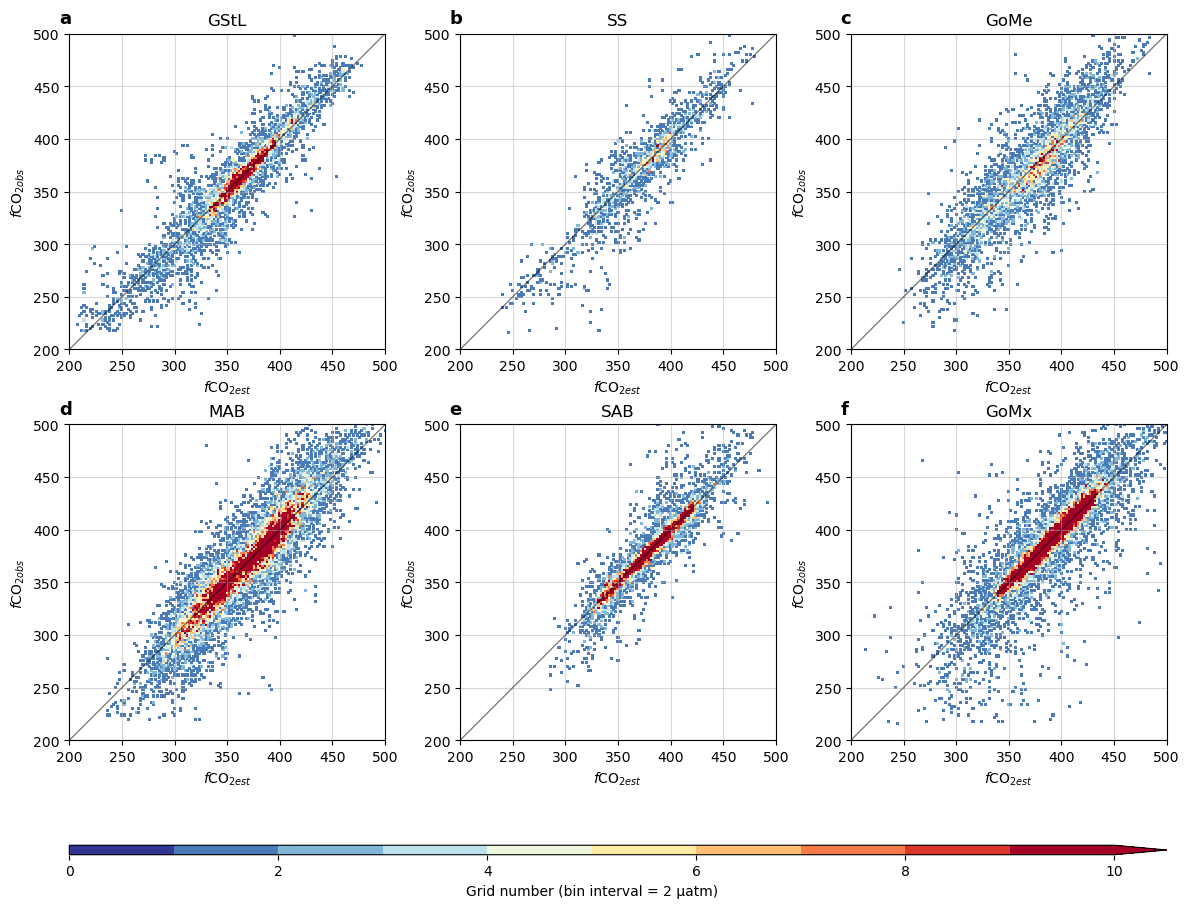

In [22]:
fig = plt.figure(figsize=(12, 9.5))
axgr = AxesGrid(fig, 111, 
                nrows_ncols=(2,3),
                axes_pad=0.75,
                cbar_location='bottom',
                cbar_mode='single',
                cbar_pad=0.3,
                cbar_size='1%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    key = key_subregions[i]
    idxvalid = ~np.isnan(fco2_product*fco2_socat*mask[key])
    x = fco2_product[idxvalid]
    y = fco2_socat[idxvalid]
    dens,x_new,y_new = bin_counts(x,y,[200,550],[200,550],2)
    nmax = 10
    ax.plot([200,550],[200,550],'k',linewidth=1,alpha=0.5)
    p = ax.pcolor(x_new,y_new,dens.T,clim=[0,nmax],cmap=plt.get_cmap('RdYlBu_r',nmax))
    ax.grid('minor',alpha=0.5)
    ax.set_xlim([200,500])
    ax.set_ylim([200,500])
    # plt.scatter(x, y)
    ax.set_title(key[5:])
    ax.text(190,510,chr(97+i),fontdict={'weight':'bold','size':13})
    ax.set_xlabel('${f}$CO$_{2est}$')
    ax.set_ylabel('${f}$CO$_{2obs}$')
axgr.cbar_axes[0].colorbar(p,extend='max',label='Grid number (bin interval = 2 µatm)')
plt.tight_layout()
# plt.savefig('figs/SI01_02_v1.jpg',dpi=600)
plt.show()

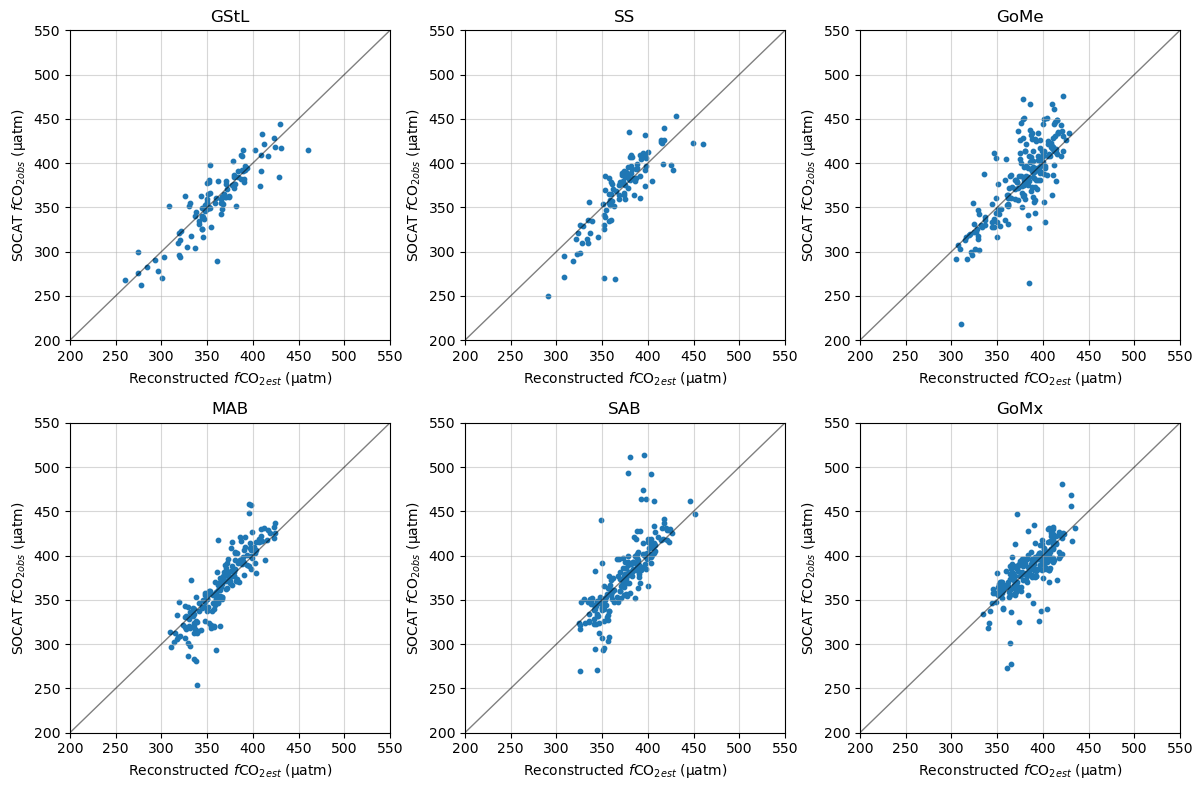

In [23]:
fig = plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(2,3,i+1)
    key = key_subregions[i]
    # idxvalid = ~np.isnan(fco2_product*diff_obs_est*mask[key])
    x = np.nanmean(fco2_product*mask[key],axis=(1,2))
    y = np.nanmean(fco2_socat*mask[key],axis=(1,2))

    ax.plot([200,550],[200,550],'k',linewidth=1,alpha=0.5)
    # dens,x_new,y_new = bin_counts(x,y,[200,550],[200,550],2)
    # nmax = 10
    # p = ax.pcolor(x_new,y_new,dens.T,clim=[0,nmax],cmap=plt.get_cmap('RdYlBu_r',nmax))
    ax.scatter(x,y,s=10)
    ax.grid('minor',alpha=0.5)
    # plt.scatter(x, y)
    ax.set_title(key[5:])
    # ax.text(190,565,chr(97+i),fontdict={'weight':'bold','size':13})
    ax.set_xlim([200,550])
    ax.set_ylim([200,550])
    ax.set_xlabel('Reconstructed ${f}$CO$_{2est}$ (µatm)')
    ax.set_ylabel('SOCAT ${f}$CO$_{2obs}$ (µatm)')
plt.tight_layout()
# plt.savefig('figs/SI01_02_v2.jpg',dpi=600)
plt.show()

In [24]:
fco2_product_4d = np.reshape(fco2_product,(np.int64(fco2_product.shape[0]/12),12,len(lat_socat),len(lon_socat)))
fco2_socat_4d = np.reshape(fco2_socat,(np.int64(fco2_socat.shape[0]/12),12,len(lat_socat),len(lon_socat)))

fco2_product_calib_4d = np.copy(fco2_product_4d)
fco2_product_calib_4d[np.isnan(fco2_socat_4d)] = np.nan

mask_product_valid = ~np.isnan(np.nanmean(fco2_product_4d,axis=0))
interval_y = 2 # 3degree
interval_x = 2 # 3degree

# fco2_product_re_clim = np.full((12,len(lat_socat),len(lon_socat)),np.nan)
# fco2_product_re_anom = np.full_like(fco2_product,np.nan)
a_clim = np.full((12,len(lat_socat),len(lon_socat)),np.nan)
a_anom = np.full((12,len(lat_socat),len(lon_socat)),np.nan)
b_clim = np.full((12,len(lat_socat),len(lon_socat)),np.nan)
b_anom = np.full((12,len(lat_socat),len(lon_socat)),np.nan)

coef_a = np.full((12,len(lat_socat),len(lon_socat)),np.nan)
coef_b = np.full((12,len(lat_socat),len(lon_socat)),np.nan)

for idxx in range(interval_x,len(lon_socat)-interval_x-1):
    for idxy in range(interval_y,len(lat_socat)-interval_y-1):
        if (mask['mask_GoMe'][0,idxy,idxx] > 0) |(mask['mask_SS'][0,idxy,idxx] > 0) | (mask['mask_GStL'][0,idxy,idxx] > 0)| (mask['mask_SAB'][0,idxy,idxx] > 0| (mask['mask_MAB'][0,idxy,idxx] > 0)):
            for idxmon in range(12):
                if mask_product_valid[idxmon,idxy,idxx]:
                    pco2_window_somfnn_i = np.copy(fco2_product_4d[:,idxmon,idxy-interval_y:idxy+interval_y+1,idxx-interval_x:idxx+interval_x+1])
                    pco2_window_socat_i = np.copy(fco2_socat_4d[:,idxmon,idxy-interval_y:idxy+interval_y+1,idxx-interval_x:idxx+interval_x+1])
                    pco2_window_somfnn_i2 = pco2_window_somfnn_i.copy()
                    pco2_window_somfnn_i2[np.isnan(pco2_window_socat_i)] = np.nan
                    ts_somfnn_x = np.nanmean(pco2_window_somfnn_i2,axis=(1,2))
                    ts_socat_y = np.nanmean(pco2_window_socat_i,axis=(1,2))
                    idxvalid = ~np.isnan(ts_somfnn_x*ts_socat_y)
                    if np.sum(idxvalid)>4:
                        ts_somfnn_x = ts_somfnn_x[idxvalid]
                        ts_socat_y = ts_socat_y[idxvalid]
                        lm_i = sm.OLS(ts_socat_y,sm.add_constant(ts_somfnn_x)).fit()
                        coef_a[idxmon,idxy,idxx] = lm_i.params[1]
                        coef_b[idxmon,idxy,idxx] = lm_i.params[0]
        else:
            pco2_window_somfnn_i = np.copy(fco2_product[:,idxy-interval_y:idxy+interval_y+1,idxx-interval_x:idxx+interval_x+1])
            pco2_window_socat_i = np.copy(fco2_socat[:,idxy-interval_y:idxy+interval_y+1,idxx-interval_x:idxx+interval_x+1])
            pco2_window_somfnn_i2 = pco2_window_somfnn_i.copy()
            pco2_window_somfnn_i2[np.isnan(pco2_window_socat_i)] = np.nan
            ts_somfnn_x = np.nanmean(pco2_window_somfnn_i2,axis=(1,2))
            ts_socat_y = np.nanmean(pco2_window_socat_i,axis=(1,2))
            idxvalid = ~np.isnan(ts_somfnn_x*ts_socat_y)
            if np.sum(idxvalid)>5:
                ts_somfnn_x = ts_somfnn_x[idxvalid]
                ts_socat_y = ts_socat_y[idxvalid]
                lm_i = sm.OLS(ts_socat_y,sm.add_constant(ts_somfnn_x)).fit()
                coef_a[:,idxy,idxx] = lm_i.params[1]
                coef_b[:,idxy,idxx] = lm_i.params[0]

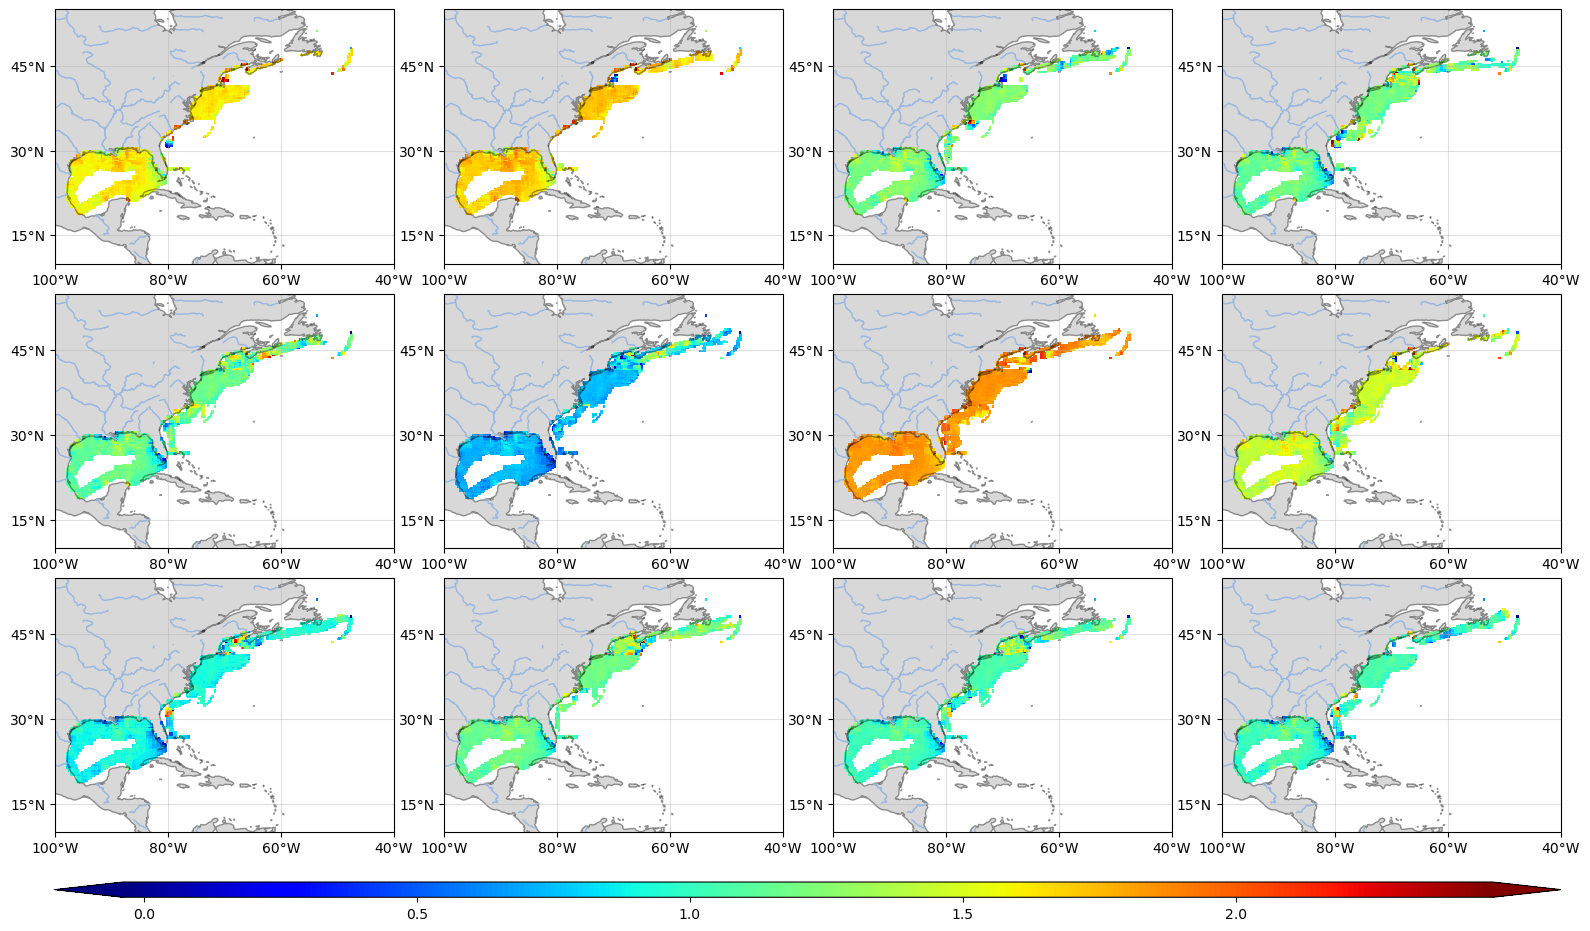

In [25]:
fig = plt.figure(figsize=(16,15))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3,4),
                axes_pad=(0.5,0.3),
                cbar_location='bottom',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='1.5%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 20), crs=projection)
    ax.set_yticks(np.arange(15,66, 15), crs=projection)
    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-100,-40])
    ax.set_ylim([10,55])

    
    p0 = ax.pcolor(lon_socat,lat_socat,coef_a[i], transform=projection,cmap=plt.get_cmap('jet',256))
cb1 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='')
plt.tight_layout()

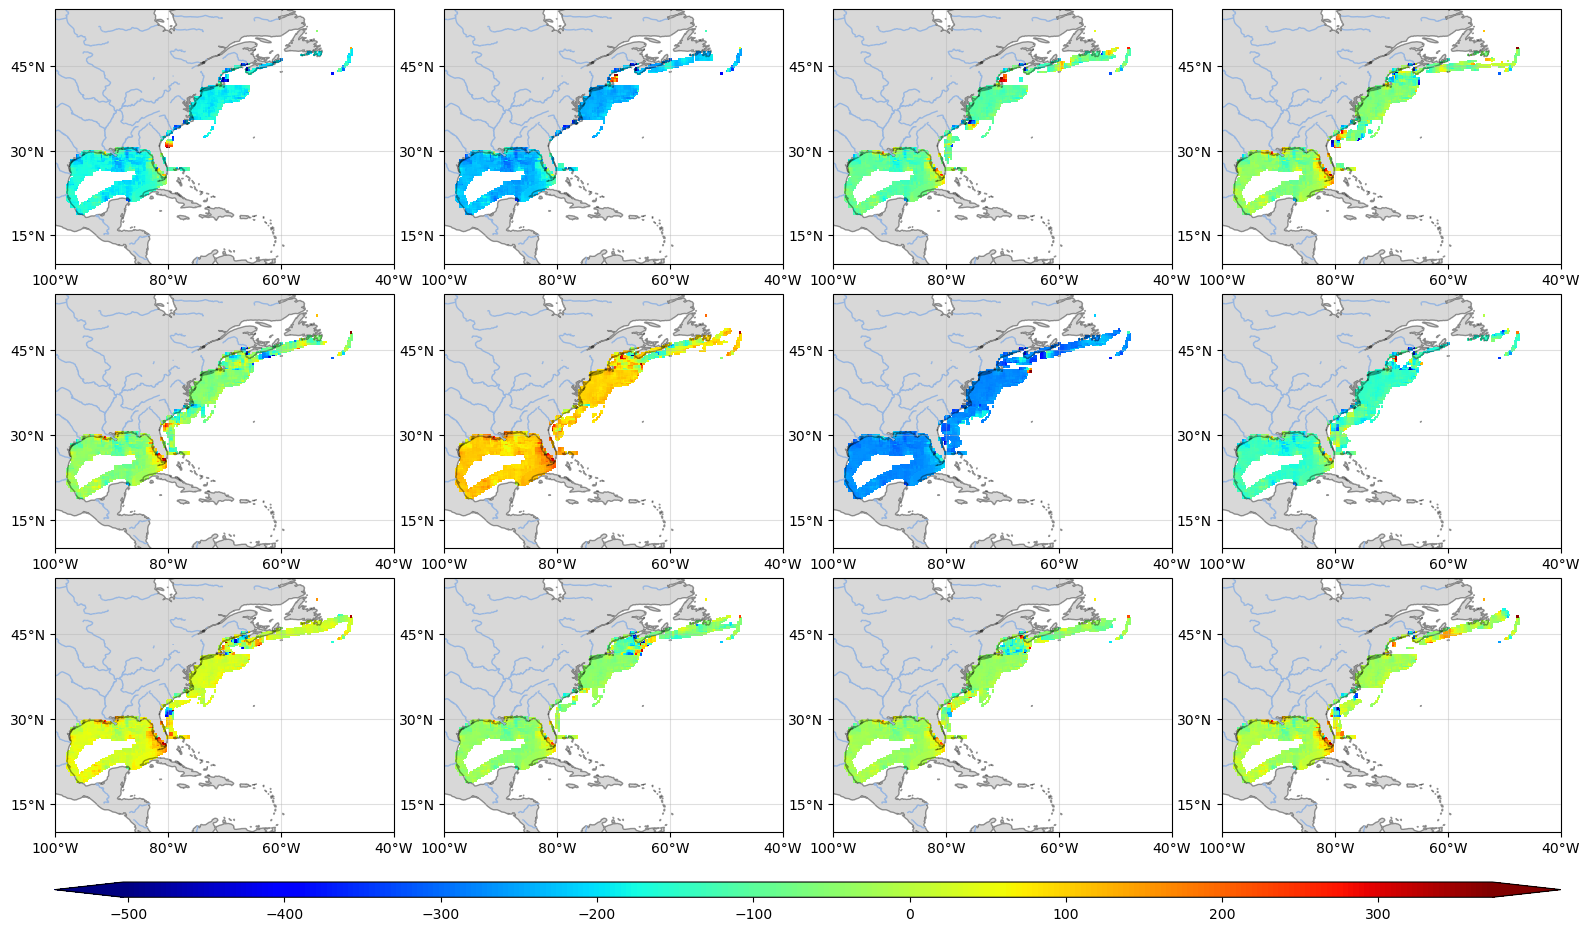

In [26]:
fig = plt.figure(figsize=(16,15))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3,4),
                axes_pad=(0.5,0.3),
                cbar_location='bottom',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='1.5%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 20), crs=projection)
    ax.set_yticks(np.arange(15,66, 15), crs=projection)
    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-100,-40])
    ax.set_ylim([10,55])

    
    p0 = ax.pcolor(lon_socat,lat_socat,coef_b[i], transform=projection,cmap=plt.get_cmap('jet',256))
cb1 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='')
plt.tight_layout()

In [27]:
from scipy.interpolate import LinearNDInterpolator
# from scipy.interpolate import RegularGridInterpolator
[time_msh,lat_msh, lon_msh] = np.meshgrid(np.arange(12),lat_socat,lon_socat,indexing='ij')

coef_a_interplated = np.full_like(lon_msh.flatten(),np.nan)
coef_b_interplated = np.full_like(lon_msh.flatten(),np.nan)

idx_Atlantic_flatten = (mask['mask_Atlantic_forinterp'].flatten()>0.5)

ivalid = ~np.isnan(coef_a*coef_b*mask['mask_Atlantic_forinterp'])
t = np.array(time_msh[ivalid])
y = np.array(lat_msh[ivalid])
x = np.array(lon_msh[ivalid])
coef_a_valid = np.array(coef_a[ivalid])
coef_b_valid = np.array(coef_b[ivalid])

# ivalid_interp = ~np.isnan(np.nanmean(fco2_product_4d,axis=0).flatten())
new_x = lon_msh.flatten()[idx_Atlantic_flatten]
new_y = lat_msh.flatten()[idx_Atlantic_flatten]
new_t = time_msh.flatten()[idx_Atlantic_flatten]

interpolator_a = LinearNDInterpolator((t, y, x), coef_a_valid)
coef_i = interpolator_a((new_t, new_y, new_x))
coef_a_interplated[idx_Atlantic_flatten] = coef_i.copy()

interpolator_b = LinearNDInterpolator((t, y, x), coef_b_valid)
coef_i = interpolator_b((new_t, new_y, new_x))
coef_b_interplated[idx_Atlantic_flatten] = coef_i.copy()

ivalid = ~np.isnan(coef_a*coef_b*mask['mask_Pacific_forinterp'])
t = np.array(time_msh[ivalid])
y = np.array(lat_msh[ivalid])
x = np.array(lon_msh[ivalid])
coef_a_valid = np.array(coef_a[ivalid])
coef_b_valid = np.array(coef_b[ivalid])

coef_a_interplated = np.reshape(coef_a_interplated,lon_msh.shape)
coef_b_interplated = np.reshape(coef_b_interplated,lon_msh.shape)

# Smooth
coef_a_interplated_smth = coef_a_interplated.copy()
coef_b_interplated_smth = coef_b_interplated.copy()
mask_all = ~np.isnan(np.nanmean(fco2_product,axis=0))

for idxy in range(1,len(lat_socat)-1):
    for idxx in range(1,len(lon_socat)-1):
        if mask_all[idxy,idxx]:
            coefi = coef_a_interplated[:,idxy-1:idxy+2,idxx-1:idxx+2]
            coef_a_interplated_smth[:,idxy,idxx] = np.nanmean(coefi,axis=(1,2))
            coefi = coef_b_interplated[:,idxy-1:idxy+2,idxx-1:idxx+2]
            coef_b_interplated_smth[:,idxy,idxx] = np.nanmean(coefi,axis=(1,2))

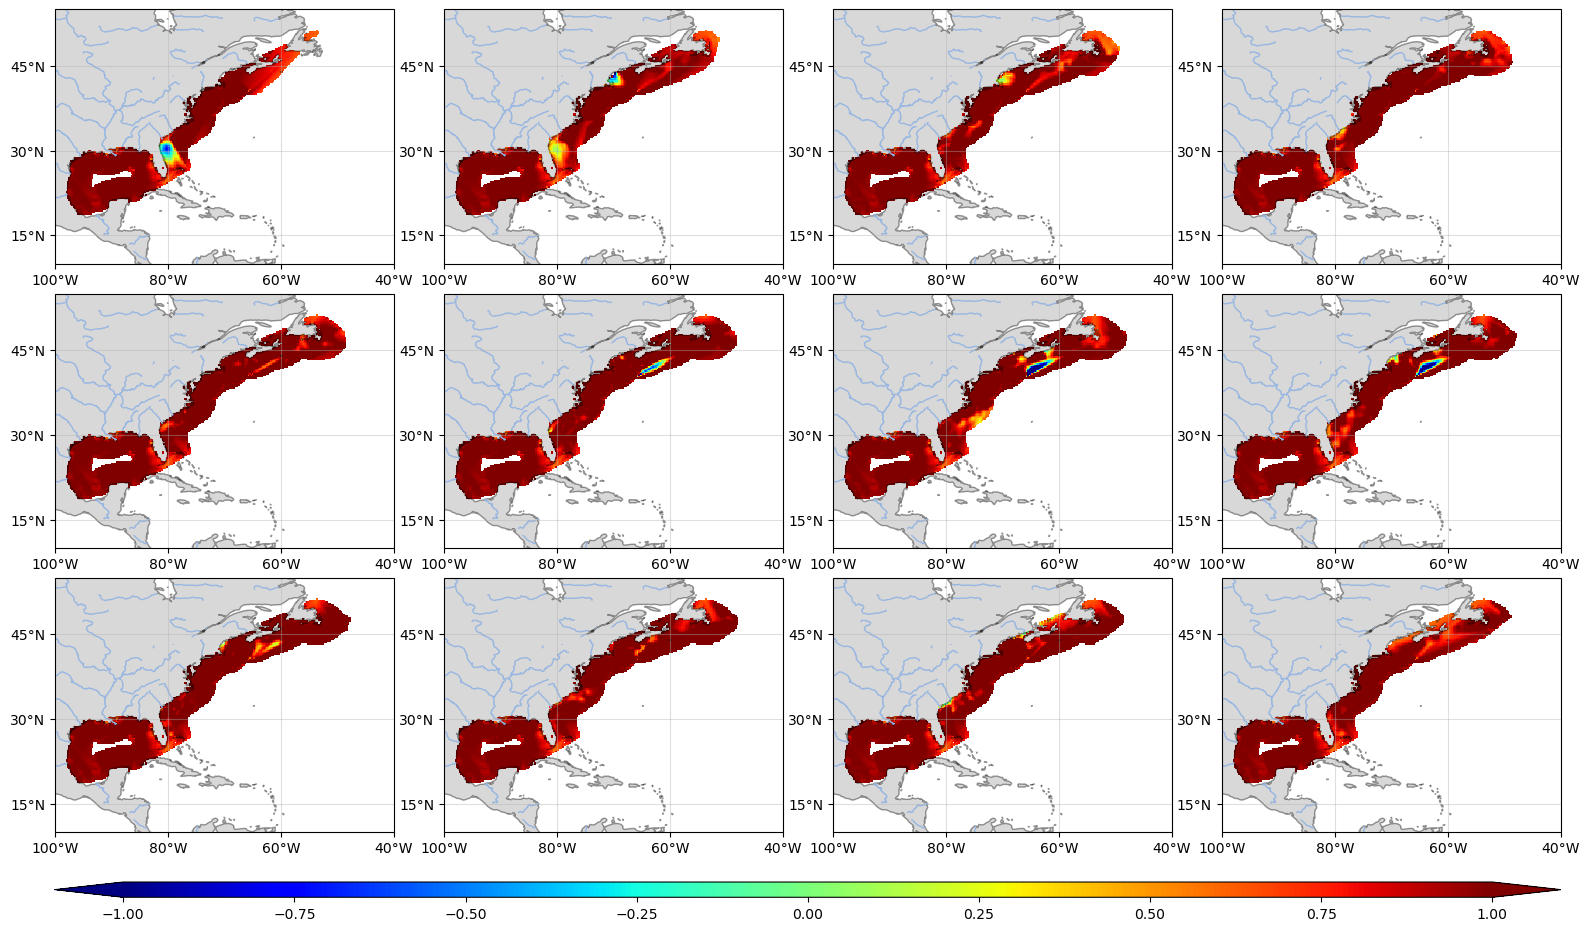

In [28]:
fig = plt.figure(figsize=(16,15))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3,4),
                axes_pad=(0.5,0.3),
                cbar_location='bottom',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='1.5%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 20), crs=projection)
    ax.set_yticks(np.arange(15,66, 15), crs=projection)
    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-100,-40])
    ax.set_ylim([10,55])

    p0 = ax.pcolor(lon_socat,lat_socat,coef_a_interplated_smth[i], transform=projection,cmap=plt.get_cmap('jet',256),clim=[-1,1])
cb1 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='')
plt.tight_layout()

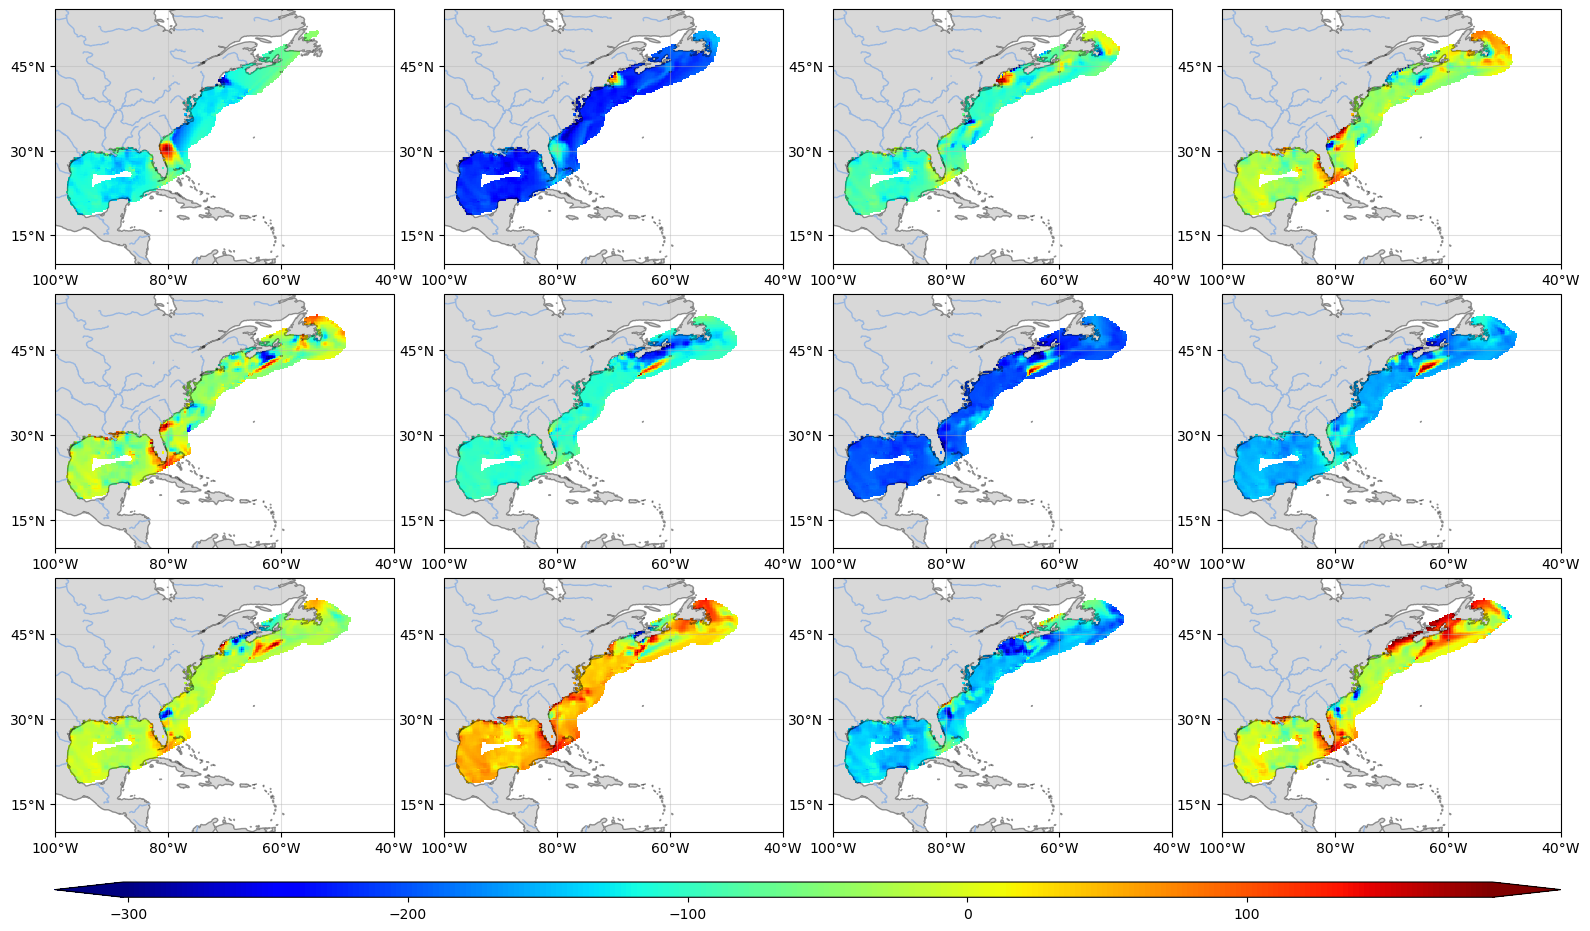

In [29]:
fig = plt.figure(figsize=(16,15))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3,4),
                axes_pad=(0.5,0.3),
                cbar_location='bottom',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='1.5%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 20), crs=projection)
    ax.set_yticks(np.arange(15,66, 15), crs=projection)
    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-100,-40])
    ax.set_ylim([10,55])

    p0 = ax.pcolor(lon_socat,lat_socat,coef_b_interplated_smth[i], transform=projection,cmap=plt.get_cmap('jet',256))
cb1 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='')
plt.tight_layout()

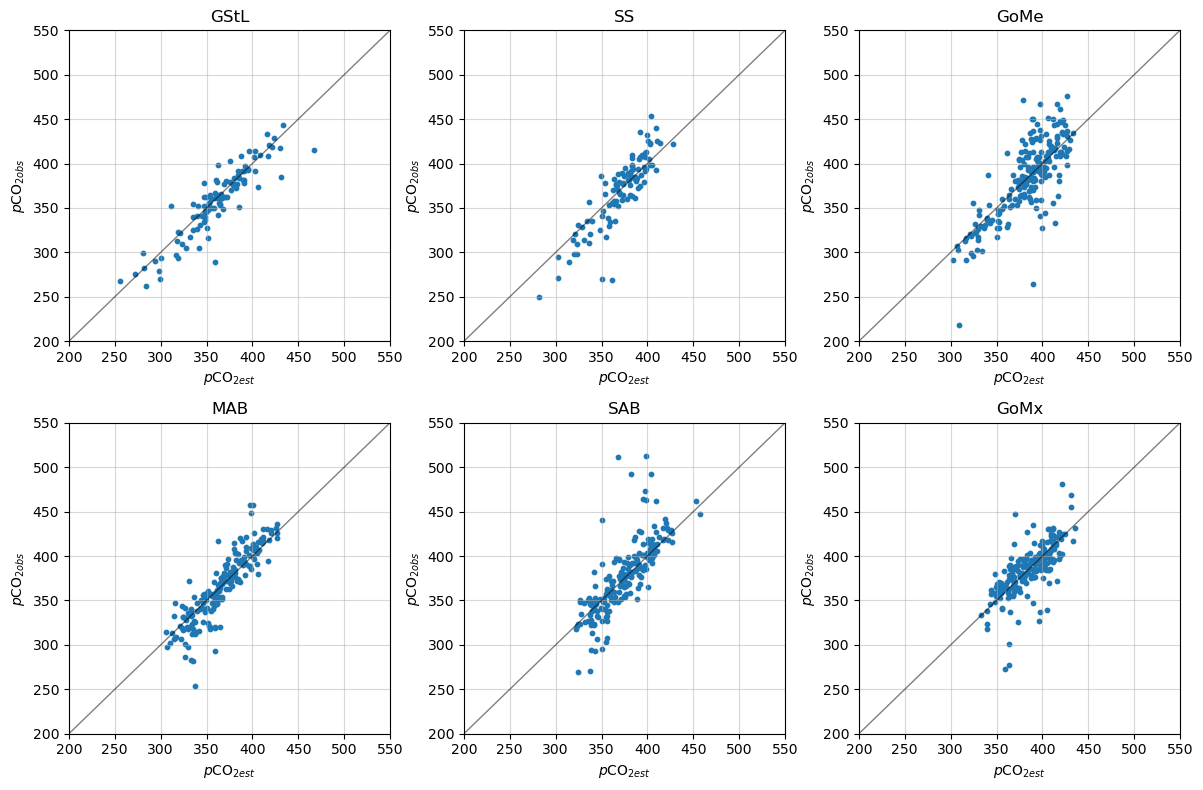

In [48]:
fco2_product_4d = np.reshape(fco2_product,(np.int64(fco2_product.shape[0]/12),12,len(lat_socat),len(lon_socat)))
# fco2_product_calib_4d = fco2_product_4d * coef_a_interplated_smth + coef_b_interplated_smth
fco2_product_calib_4d = fco2_product_4d * coef_a_interplated + coef_b_interplated

fco2_product_calib = np.reshape(fco2_product_calib_4d,fco2_product.shape)
# fco2_product_calib_smth = fco2_product_calib.copy()
# for idxt in range(fco2_product_calib.shape[0]):
#     for idxlat in range(1,len(lat_socat)-1):
#         for idxlon in range(1,len(lon_socat)-1):
#             if ~np.isnan(fco2_product_calib[idxt,idxlat,idxlon]):
#                 fco2_product_calib_smth[idxt,idxlat,idxlon] = np.nanmean(fco2_product_calib[idxt,idxlat-1:idxlat+2,idxlon-1:idxlon+2])
# fco2_product_calib = fco2_product_calib_smth
fco2_product_calib_4d = np.reshape(fco2_product_calib,fco2_product_4d.shape)
fig = plt.figure(figsize=(12,8))
for i in range(6):
    ax = plt.subplot(2,3,i+1)
    key = key_subregions[i]
    # idxvalid = ~np.isnan(fco2_product*diff_obs_est*mask[key])
    x = np.nanmean(fco2_product_calib*mask[key],axis=(1,2))
    y = np.nanmean(fco2_socat*mask[key],axis=(1,2))

    ax.plot([200,550],[200,550],'k',linewidth=1,alpha=0.5)
    # dens,x_new,y_new = bin_counts(x,y,[200,550],[200,550],2)
    # nmax = 10
    # p = ax.pcolor(x_new,y_new,dens.T,clim=[0,nmax],cmap=plt.get_cmap('RdYlBu_r',nmax))
    ax.scatter(x,y,s=10)
    ax.grid('minor',alpha=0.5)
    # plt.scatter(x, y)
    ax.set_title(key[5:])
    # ax.text(190,565,chr(97+i),fontdict={'weight':'bold','size':13})
    ax.set_xlim([200,550])
    ax.set_ylim([200,550])
    ax.set_xlabel('${p}$CO$_{2est}$')
    ax.set_ylabel('${p}$CO$_{2obs}$')
plt.tight_layout()
# plt.savefig('figs/SI01_02_v2.jpg',dpi=600)
plt.show()


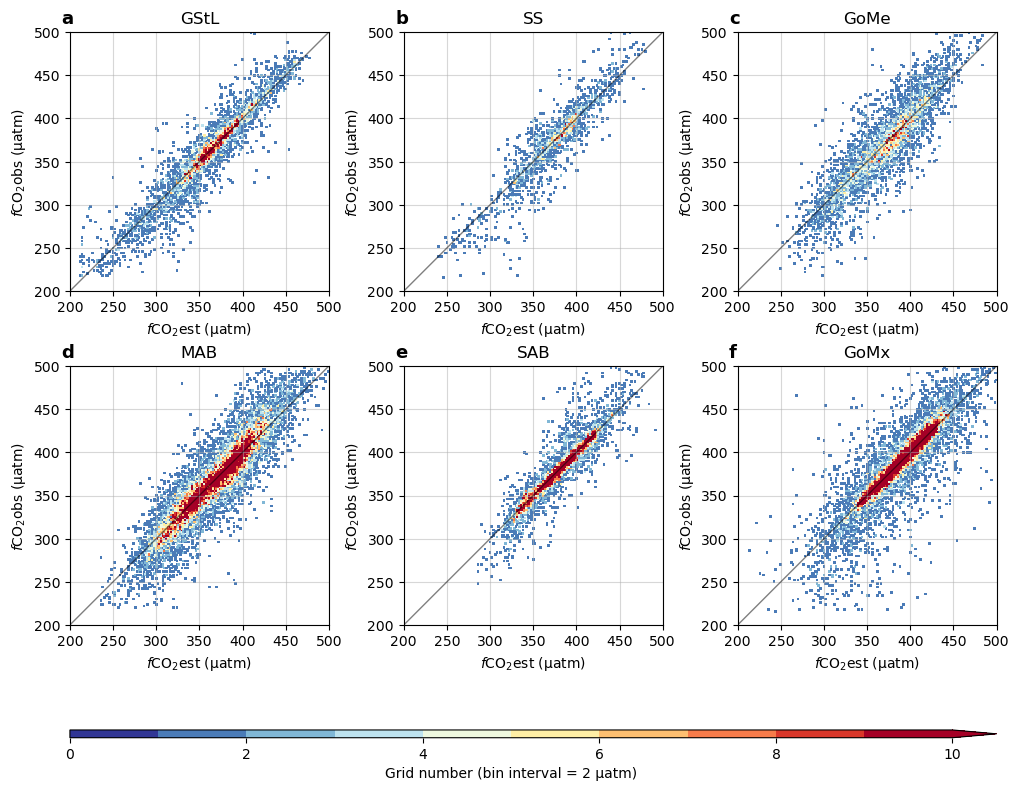

In [49]:
fig = plt.figure(figsize=(12, 8))
axgr = AxesGrid(fig, 111, 
                nrows_ncols=(2,3),
                axes_pad=0.75,
                cbar_location='bottom',
                cbar_mode='single',
                cbar_pad=0.3,
                cbar_size='1%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    key = key_subregions[i]
    idxvalid = ~np.isnan(fco2_product_calib*fco2_socat*mask[key])
    x = fco2_product[idxvalid]
    y = fco2_socat[idxvalid]
    dens,x_new,y_new = bin_counts(x,y,[200,550],[200,550],2)
    nmax = 10
    ax.plot([200,550],[200,550],'k',linewidth=1,alpha=0.5)
    p = ax.pcolor(x_new,y_new,dens.T,clim=[0,nmax],cmap=plt.get_cmap('RdYlBu_r',nmax))
    ax.grid('minor',alpha=0.5)
    ax.set_xlim([200,500])
    ax.set_ylim([200,500])
    # plt.scatter(x, y)
    ax.set_title(key[5:])
    ax.text(190,510,chr(97+i),fontdict={'weight':'bold','size':13})
    ax.set_xlabel('${f}$CO$_{2}$est (µatm)')
    ax.set_ylabel('${f}$CO$_{2}$obs (µatm)')
axgr.cbar_axes[0].colorbar(p,extend='max',label='Grid number (bin interval = 2 µatm)')
plt.tight_layout()
# plt.savefig('figs/SI01_02_v1.jpg',dpi=600)
plt.show()

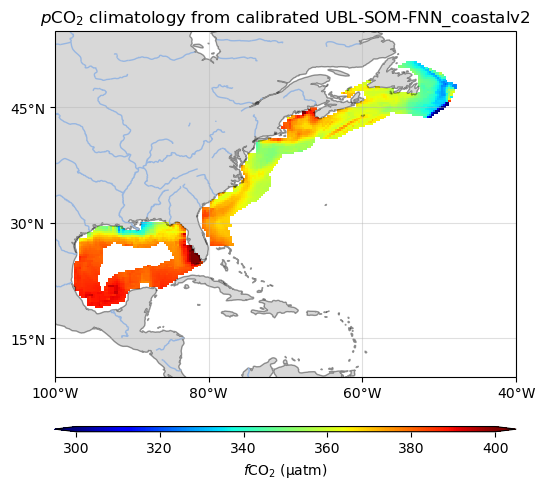

In [50]:
diff_calib_est = fco2_product_calib - fco2_socat

fig = plt.figure(figsize=(8,5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1,1),
                axes_pad=(0.5,0.3),
                cbar_location='bottom',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='1.5%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 20), crs=projection)
    ax.set_yticks(np.arange(15,66, 15), crs=projection)
    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-100,-40])
    ax.set_ylim([10,55])

    if i == 0:
        p0 = ax.pcolor(lon_socat,lat_socat,np.nanmean(fco2_product_calib,axis=0)*mask['mask_NAC2'][0], transform=projection,cmap=plt.get_cmap('jet',256),clim=[300,400])
        ax.set_title('$p$CO$_2$ climatology from calibrated UBL-SOM-FNN_coastalv2')
cb1 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='${f}$CO$_2$ (µatm)')
plt.tight_layout()
# plt.savefig('figs/SI01_01_01.jpg',dpi=600)
plt.show()

In [51]:
#%%
fco2_product_nan = np.copy(fco2_product)
fco2_product_nan[np.isnan(fco2_socat)] = np.nan
fco2_product_calib2 = np.copy(fco2_product_calib)
fco2_product_calib2[np.isnan(fco2_socat)] = np.nan

ts_product_AL = np.nanmean(fco2_product_nan*mask['mask_AL'],axis=(1,2))
ts_product_re_AL = np.nanmean(fco2_product_calib2*mask['mask_AL'],axis=(1,2))
ts_socat_AL = np.nanmean(fco2_socat*mask['mask_AL'],axis=(1,2))
ts_socat_AL[(ts_socat_AL<=np.nanmean(ts_socat_AL)-3*np.nanstd(ts_socat_AL))] = np.nan
ts_socat_AL[(ts_socat_AL>=np.nanmean(ts_socat_AL)+3*np.nanstd(ts_socat_AL))] = np.nan
ts_product_AL_clim = np.nanmean(np.reshape(ts_product_AL,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_AL_anom= ts_product_AL - np.repeat(ts_product_AL_clim,fco2_product_4d.shape[0])
ts_product_re_AL_clim = np.nanmean(np.reshape(ts_product_re_AL,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_re_AL_anom= ts_product_re_AL - np.repeat(ts_product_re_AL_clim,fco2_product_4d.shape[0])
ts_socat_AL_clim = np.nanmean(np.reshape(ts_socat_AL,(fco2_product_4d.shape[0],12)),axis=0)
ts_socat_AL_anom= ts_socat_AL - np.repeat(ts_socat_AL_clim,fco2_product_4d.shape[0])

ts_product_NCCS = np.nanmean(fco2_product_nan*mask['mask_NCCS'],axis=(1,2))
ts_product_re_NCCS = np.nanmean(fco2_product_calib2*mask['mask_NCCS'],axis=(1,2))
ts_socat_NCCS = np.nanmean(fco2_socat*mask['mask_NCCS'],axis=(1,2))
ts_socat_NCCS[(ts_socat_NCCS<=np.nanmean(ts_socat_NCCS)-3*np.nanstd(ts_socat_NCCS))] = np.nan
ts_socat_NCCS[(ts_socat_NCCS>=np.nanmean(ts_socat_NCCS)+3*np.nanstd(ts_socat_NCCS))] = np.nan
ts_product_NCCS_clim = np.nanmean(np.reshape(ts_product_NCCS,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_NCCS_anom= ts_product_NCCS - np.repeat(ts_product_NCCS_clim,fco2_product_4d.shape[0])
ts_product_re_NCCS_clim = np.nanmean(np.reshape(ts_product_re_NCCS,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_re_NCCS_anom= ts_product_re_NCCS - np.repeat(ts_product_re_NCCS_clim,fco2_product_4d.shape[0])
ts_socat_NCCS_clim = np.nanmean(np.reshape(ts_socat_NCCS,(fco2_product_4d.shape[0],12)),axis=0)
ts_socat_NCCS_anom= ts_socat_NCCS - np.repeat(ts_socat_NCCS_clim,fco2_product_4d.shape[0])

ts_product_CCCS = np.nanmean(fco2_product_nan*mask['mask_CCCS'],axis=(1,2))
ts_product_re_CCCS = np.nanmean(fco2_product_calib2*mask['mask_CCCS'],axis=(1,2))
ts_socat_CCCS = np.nanmean(fco2_socat*mask['mask_CCCS'],axis=(1,2))
ts_socat_CCCS[(ts_socat_CCCS<=np.nanmean(ts_socat_CCCS)-3*np.nanstd(ts_socat_CCCS))] = np.nan
ts_socat_CCCS[(ts_socat_CCCS>=np.nanmean(ts_socat_CCCS)+3*np.nanstd(ts_socat_CCCS))] = np.nan
ts_product_CCCS_clim = np.nanmean(np.reshape(ts_product_CCCS,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_CCCS_anom= ts_product_CCCS - np.repeat(ts_product_CCCS_clim,fco2_product_4d.shape[0])
ts_product_re_CCCS_clim = np.nanmean(np.reshape(ts_product_re_CCCS,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_re_CCCS_anom= ts_product_re_CCCS - np.repeat(ts_product_re_CCCS_clim,fco2_product_4d.shape[0])
ts_socat_CCCS_clim = np.nanmean(np.reshape(ts_socat_CCCS,(fco2_product_4d.shape[0],12)),axis=0)
ts_socat_CCCS_anom= ts_socat_CCCS - np.repeat(ts_socat_CCCS_clim,fco2_product_4d.shape[0])

ts_product_SCCS = np.nanmean(fco2_product_nan*mask['mask_SCCS'],axis=(1,2))
ts_product_re_SCCS = np.nanmean(fco2_product_calib2*mask['mask_SCCS'],axis=(1,2))
ts_socat_SCCS = np.nanmean(fco2_socat*mask['mask_SCCS'],axis=(1,2))
ts_socat_SCCS[(ts_socat_SCCS<=np.nanmean(ts_socat_SCCS)-3*np.nanstd(ts_socat_SCCS))] = np.nan
ts_socat_SCCS[(ts_socat_SCCS>=np.nanmean(ts_socat_SCCS)+3*np.nanstd(ts_socat_SCCS))] = np.nan
ts_product_SCCS_clim = np.nanmean(np.reshape(ts_product_SCCS,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_SCCS_anom= ts_product_SCCS - np.repeat(ts_product_SCCS_clim,fco2_product_4d.shape[0])
ts_product_re_SCCS_clim = np.nanmean(np.reshape(ts_product_re_SCCS,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_re_SCCS_anom= ts_product_re_SCCS - np.repeat(ts_product_re_SCCS_clim,fco2_product_4d.shape[0])
ts_socat_SCCS_clim = np.nanmean(np.reshape(ts_socat_SCCS,(fco2_product_4d.shape[0],12)),axis=0)
ts_socat_SCCS_anom= ts_socat_SCCS - np.repeat(ts_socat_SCCS_clim,fco2_product_4d.shape[0])

ts_product_Isth = np.nanmean(fco2_product_nan*mask['mask_Isth'],axis=(1,2))
ts_product_re_Isth = np.nanmean(fco2_product_calib2*mask['mask_Isth'],axis=(1,2))
ts_socat_Isth = np.nanmean(fco2_socat*mask['mask_Isth'],axis=(1,2))
ts_socat_Isth[(ts_socat_Isth<=np.nanmean(ts_socat_Isth)-3*np.nanstd(ts_socat_Isth))] = np.nan
ts_socat_Isth[(ts_socat_Isth>=np.nanmean(ts_socat_Isth)+3*np.nanstd(ts_socat_Isth))] = np.nan
ts_product_Isth_clim = np.nanmean(np.reshape(ts_product_Isth,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_Isth_anom= ts_product_Isth - np.repeat(ts_product_Isth_clim,fco2_product_4d.shape[0])
ts_product_re_Isth_clim = np.nanmean(np.reshape(ts_product_re_Isth,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_re_Isth_anom= ts_product_re_Isth - np.repeat(ts_product_re_Isth_clim,fco2_product_4d.shape[0])
ts_socat_Isth_clim = np.nanmean(np.reshape(ts_socat_Isth,(fco2_product_4d.shape[0],12)),axis=0)
ts_socat_Isth_anom= ts_socat_Isth - np.repeat(ts_socat_Isth_clim,fco2_product_4d.shape[0])

ts_product_GStL = np.nanmean(fco2_product_nan*mask['mask_GStL'],axis=(1,2))
ts_product_re_GStL = np.nanmean(fco2_product_calib2*mask['mask_GStL'],axis=(1,2))
ts_socat_GStL = np.nanmean(fco2_socat*mask['mask_GStL'],axis=(1,2))
ts_socat_GStL[(ts_socat_GStL<=np.nanmean(ts_socat_GStL)-3*np.nanstd(ts_socat_GStL))] = np.nan
ts_socat_GStL[(ts_socat_GStL>=np.nanmean(ts_socat_GStL)+3*np.nanstd(ts_socat_GStL))] = np.nan
ts_product_GStL_clim = np.nanmean(np.reshape(ts_product_GStL,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_GStL_anom= ts_product_GStL - np.repeat(ts_product_GStL_clim,fco2_product_4d.shape[0])
ts_product_re_GStL_clim = np.nanmean(np.reshape(ts_product_re_GStL,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_re_GStL_anom= ts_product_re_GStL - np.repeat(ts_product_re_GStL_clim,fco2_product_4d.shape[0])
ts_socat_GStL_clim = np.nanmean(np.reshape(ts_socat_GStL,(fco2_product_4d.shape[0],12)),axis=0)
ts_socat_GStL_anom= ts_socat_GStL - np.repeat(ts_socat_GStL_clim,fco2_product_4d.shape[0])

ts_product_GoMe = np.nanmean(fco2_product_nan*mask['mask_GoMe'],axis=(1,2))
ts_product_re_GoMe = np.nanmean(fco2_product_calib2*mask['mask_GoMe'],axis=(1,2))
ts_socat_GoMe = np.nanmean(fco2_socat*mask['mask_GoMe'],axis=(1,2))
ts_socat_GoMe[(ts_socat_GoMe<=np.nanmean(ts_socat_GoMe)-3*np.nanstd(ts_socat_GoMe))] = np.nan
ts_socat_GoMe[(ts_socat_GoMe>=np.nanmean(ts_socat_GoMe)+3*np.nanstd(ts_socat_GoMe))] = np.nan
ts_product_GoMe_clim = np.nanmean(np.reshape(ts_product_GoMe,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_GoMe_anom= ts_product_GoMe - np.repeat(ts_product_GoMe_clim,fco2_product_4d.shape[0])
ts_product_re_GoMe_clim = np.nanmean(np.reshape(ts_product_re_GoMe,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_re_GoMe_anom= ts_product_re_GoMe - np.repeat(ts_product_re_GoMe_clim,fco2_product_4d.shape[0])
ts_socat_GoMe_clim = np.nanmean(np.reshape(ts_socat_GoMe,(fco2_product_4d.shape[0],12)),axis=0)
ts_socat_GoMe_anom= ts_socat_GoMe - np.repeat(ts_socat_GoMe_clim,fco2_product_4d.shape[0])

ts_product_SS = np.nanmean(fco2_product_nan*mask['mask_SS'],axis=(1,2))
ts_product_re_SS = np.nanmean(fco2_product_calib2*mask['mask_SS'],axis=(1,2))
ts_socat_SS = np.nanmean(fco2_socat*mask['mask_SS'],axis=(1,2))
ts_socat_SS[(ts_socat_SS<=np.nanmean(ts_socat_SS)-3*np.nanstd(ts_socat_SS))] = np.nan
ts_socat_SS[(ts_socat_SS>=np.nanmean(ts_socat_SS)+3*np.nanstd(ts_socat_SS))] = np.nan
ts_product_SS_clim = np.nanmean(np.reshape(ts_product_SS,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_SS_anom= ts_product_SS - np.repeat(ts_product_SS_clim,fco2_product_4d.shape[0])
ts_product_re_SS_clim = np.nanmean(np.reshape(ts_product_re_SS,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_re_SS_anom= ts_product_re_SS - np.repeat(ts_product_re_SS_clim,fco2_product_4d.shape[0])
ts_socat_SS_clim = np.nanmean(np.reshape(ts_socat_SS,(fco2_product_4d.shape[0],12)),axis=0)
ts_socat_SS_anom= ts_socat_SS - np.repeat(ts_socat_SS_clim,fco2_product_4d.shape[0])

ts_product_SAB = np.nanmean(fco2_product_nan*mask['mask_SAB'],axis=(1,2))
ts_product_re_SAB = np.nanmean(fco2_product_calib2*mask['mask_SAB'],axis=(1,2))
ts_socat_SAB = np.nanmean(fco2_socat*mask['mask_SAB'],axis=(1,2))
ts_socat_SAB[(ts_socat_SAB<=np.nanmean(ts_socat_SAB)-3*np.nanstd(ts_socat_SAB))] = np.nan
ts_socat_SAB[(ts_socat_SAB>=np.nanmean(ts_socat_SAB)+3*np.nanstd(ts_socat_SAB))] = np.nan
ts_product_SAB_clim = np.nanmean(np.reshape(ts_product_SAB,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_SAB_anom= ts_product_SAB - np.repeat(ts_product_SAB_clim,fco2_product_4d.shape[0])
ts_product_re_SAB_clim = np.nanmean(np.reshape(ts_product_re_SAB,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_re_SAB_anom= ts_product_re_SAB - np.repeat(ts_product_re_SAB_clim,fco2_product_4d.shape[0])
ts_socat_SAB_clim = np.nanmean(np.reshape(ts_socat_SAB,(fco2_product_4d.shape[0],12)),axis=0)
ts_socat_SAB_anom= ts_socat_SAB - np.repeat(ts_socat_SAB_clim,fco2_product_4d.shape[0])

ts_product_MAB = np.nanmean(fco2_product_nan*mask['mask_MAB'],axis=(1,2))
ts_product_re_MAB = np.nanmean(fco2_product_calib2*mask['mask_MAB'],axis=(1,2))
ts_socat_MAB = np.nanmean(fco2_socat*mask['mask_MAB'],axis=(1,2))
ts_socat_MAB[(ts_socat_MAB<=np.nanmean(ts_socat_MAB)-3*np.nanstd(ts_socat_MAB))] = np.nan
ts_socat_MAB[(ts_socat_MAB>=np.nanmean(ts_socat_MAB)+3*np.nanstd(ts_socat_MAB))] = np.nan
ts_product_MAB_clim = np.nanmean(np.reshape(ts_product_MAB,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_MAB_anom= ts_product_MAB - np.repeat(ts_product_MAB_clim,fco2_product_4d.shape[0])
ts_product_re_MAB_clim = np.nanmean(np.reshape(ts_product_re_MAB,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_re_MAB_anom= ts_product_re_MAB - np.repeat(ts_product_re_MAB_clim,fco2_product_4d.shape[0])
ts_socat_MAB_clim = np.nanmean(np.reshape(ts_socat_MAB,(fco2_product_4d.shape[0],12)),axis=0)
ts_socat_MAB_anom= ts_socat_MAB - np.repeat(ts_socat_MAB_clim,fco2_product_4d.shape[0])

ts_product_GoMx = np.nanmean(fco2_product_nan*mask['mask_GoMx'],axis=(1,2))
ts_product_re_GoMx = np.nanmean(fco2_product_calib2*mask['mask_GoMx'],axis=(1,2))
ts_socat_GoMx = np.nanmean(fco2_socat*mask['mask_GoMx'],axis=(1,2))
ts_socat_GoMx[(ts_socat_GoMx<=np.nanmean(ts_socat_GoMx)-3*np.nanstd(ts_socat_GoMx))] = np.nan
ts_socat_GoMx[(ts_socat_GoMx>=np.nanmean(ts_socat_GoMx)+3*np.nanstd(ts_socat_GoMx))] = np.nan
ts_product_GoMx_clim = np.nanmean(np.reshape(ts_product_GoMx,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_GoMx_anom= ts_product_GoMx - np.repeat(ts_product_GoMx_clim,fco2_product_4d.shape[0])
ts_product_re_GoMx_clim = np.nanmean(np.reshape(ts_product_re_GoMx,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_re_GoMx_anom= ts_product_re_GoMx - np.repeat(ts_product_re_GoMx_clim,fco2_product_4d.shape[0])
ts_socat_GoMx_clim = np.nanmean(np.reshape(ts_socat_GoMx,(fco2_product_4d.shape[0],12)),axis=0)
ts_socat_GoMx_anom= ts_socat_GoMx - np.repeat(ts_socat_GoMx_clim,fco2_product_4d.shape[0])

ts_product_CbS = np.nanmean(fco2_product_nan*mask['mask_CbS'],axis=(1,2))
ts_product_re_CbS = np.nanmean(fco2_product_calib2*mask['mask_CbS'],axis=(1,2))
ts_socat_CbS = np.nanmean(fco2_socat*mask['mask_CbS'],axis=(1,2))
ts_socat_CbS[(ts_socat_CbS<=np.nanmean(ts_socat_CbS)-3*np.nanstd(ts_socat_CbS))] = np.nan
ts_socat_CbS[(ts_socat_CbS>=np.nanmean(ts_socat_CbS)+3*np.nanstd(ts_socat_CbS))] = np.nan
ts_product_CbS_clim = np.nanmean(np.reshape(ts_product_CbS,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_CbS_anom= ts_product_CbS - np.repeat(ts_product_CbS_clim,fco2_product_4d.shape[0])
ts_product_re_CbS_clim = np.nanmean(np.reshape(ts_product_re_CbS,(fco2_product_4d.shape[0],12)),axis=0)
ts_product_re_CbS_anom= ts_product_re_CbS - np.repeat(ts_product_re_CbS_clim,fco2_product_4d.shape[0])
ts_socat_CbS_clim = np.nanmean(np.reshape(ts_socat_CbS,(fco2_product_4d.shape[0],12)),axis=0)
ts_socat_CbS_anom= ts_socat_CbS - np.repeat(ts_socat_CbS_clim,fco2_product_4d.shape[0])
#%%


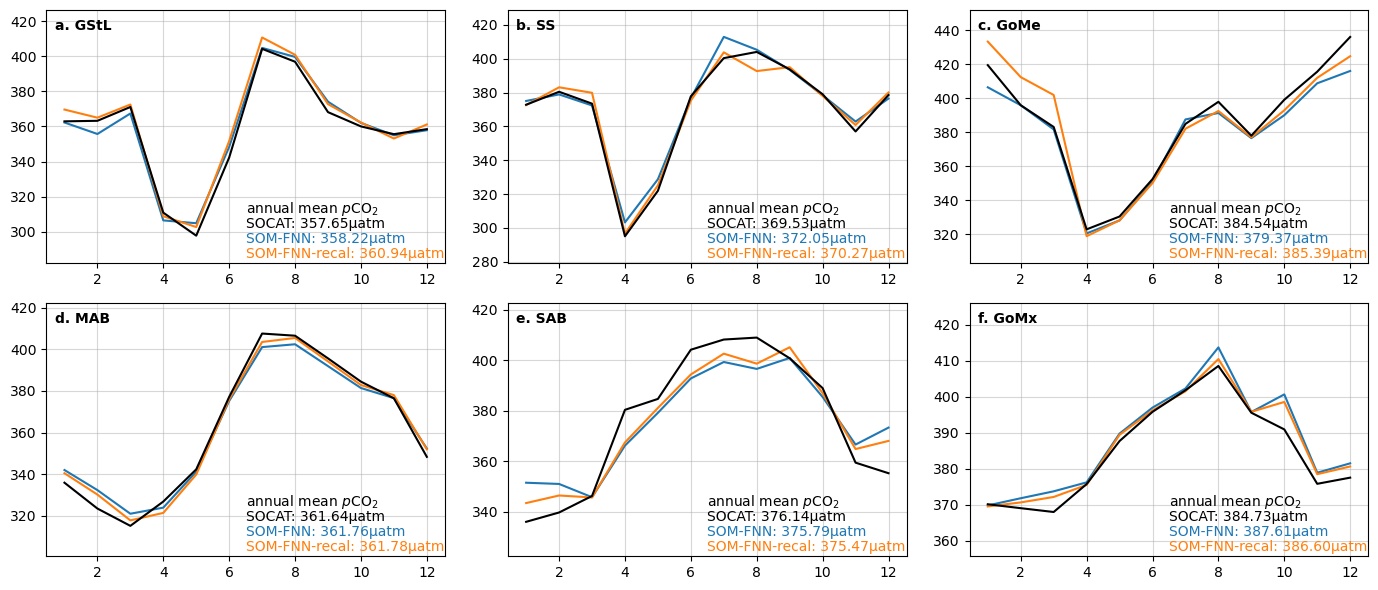

In [52]:
plt.figure(figsize=(14,6))
plt.subplots_adjust(left=0.07,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.15,
                    hspace=0.15)
idxf = 1

ax = plt.subplot(2,3,idxf)
plt.plot(range(1,13),ts_product_GStL_clim,label='product',c='tab:blue')
plt.plot(range(1,13),ts_product_re_GStL_clim,label='product_re',c='tab:orange')
plt.plot(range(1,13),ts_socat_GStL_clim,label='socat',c='k')
ivalid = ~np.isnan(ts_product_GStL_clim*ts_socat_GStL_clim)
# lm_i1 = sm.OLS(ts_socat_GStL_clim[ivalid],sm.add_constant(ts_product_GStL_clim[ivalid])).fit()
# lm_i2= sm.OLS(ts_socat_GStL_clim[ivalid],sm.add_constant(ts_product_re_GStL_clim[ivalid])).fit()
ylim = np.array(ax.get_ylim())
ylim[0] = ylim[0] - 10
ylim[1] = ylim[1] + 10
ax.set_ylim(ylim)
plt.grid('on',alpha=0.5)
# ax.text(3,ylim[0]+0.92*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN) = ' + '%.2f' % lm_i1.rsquared,fontdict={'color':'tab:blue'})
# ax.text(3,ylim[0]+0.87*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN-recal) = ' + '%.2f' % lm_i2.rsquared,fontdict={'color':'tab:orange'})
ax.text(6.5,ylim[0]+0.2*(ylim[1]-ylim[0]),'annual mean $p$CO$_2$')
ax.text(6.5,ylim[0]+0.08*(ylim[1]-ylim[0]),'SOM-FNN: '+'%.2f' % np.nanmean(ts_product_GStL_clim) + 'µatm',fontdict={'color':'tab:blue'})
ax.text(6.5,ylim[0]+0.02*(ylim[1]-ylim[0]),'SOM-FNN-recal: '+'%.2f' % np.nanmean(ts_product_re_GStL_clim) + 'µatm',fontdict={'color':'tab:orange'})
ax.text(6.5,ylim[0]+0.14*(ylim[1]-ylim[0]),'SOCAT: '+'%.2f' % np.nanmean(ts_socat_GStL_clim)+ 'µatm',fontdict={'color':'k'})
ax.text(0.7,ylim[1]-0.08*(ylim[1]-ylim[0]),chr(96+idxf) + '. GStL',fontdict={'weight':'bold'})

idxf = idxf + 1
ax = plt.subplot(2,3,idxf)
plt.plot(range(1,13),ts_product_SS_clim,label='product',c='tab:blue')
plt.plot(range(1,13),ts_product_re_SS_clim,label='product_re',c='tab:orange')
plt.plot(range(1,13),ts_socat_SS_clim,label='socat',c='k')
ivalid = ~np.isnan(ts_product_SS_clim*ts_socat_SS_clim)
# # lm_i1 = sm.OLS(ts_socat_SS_clim[ivalid],sm.add_constant(ts_product_SS_clim[ivalid])).fit()
# # lm_i2= sm.OLS(ts_socat_SS_clim[ivalid],sm.add_constant(ts_product_re_SS_clim[ivalid])).fit()
ylim = np.array(ax.get_ylim())
ylim[0] = ylim[0] - 10
ylim[1] = ylim[1] + 10
ax.set_ylim(ylim)
plt.grid('on',alpha=0.5)
# # ax.text(3,ylim[0]+0.92*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN) = ' + '%.2f' % lm_i1.rsquared,fontdict={'color':'tab:blue'})
# # ax.text(3,ylim[0]+0.87*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN-recal) = ' + '%.2f' % lm_i2.rsquared,fontdict={'color':'tab:orange'})
ax.text(6.5,ylim[0]+0.2*(ylim[1]-ylim[0]),'annual mean $p$CO$_2$')
ax.text(6.5,ylim[0]+0.08*(ylim[1]-ylim[0]),'SOM-FNN: '+'%.2f' % np.nanmean(ts_product_SS_clim) + 'µatm',fontdict={'color':'tab:blue'})
ax.text(6.5,ylim[0]+0.02*(ylim[1]-ylim[0]),'SOM-FNN-recal: '+'%.2f' % np.nanmean(ts_product_re_SS_clim) + 'µatm',fontdict={'color':'tab:orange'})
ax.text(6.5,ylim[0]+0.14*(ylim[1]-ylim[0]),'SOCAT: '+'%.2f' % np.nanmean(ts_socat_SS_clim)+ 'µatm',fontdict={'color':'k'})
ax.text(0.7,ylim[1]-0.08*(ylim[1]-ylim[0]),chr(96+idxf) + '. SS',fontdict={'weight':'bold'})

idxf = idxf + 1
ax = plt.subplot(2,3,idxf)
plt.plot(range(1,13),ts_product_GoMe_clim,label='product',c='tab:blue')
plt.plot(range(1,13),ts_product_re_GoMe_clim,label='product_re',c='tab:orange')
plt.plot(range(1,13),ts_socat_GoMe_clim,label='socat',c='k')
ivalid = ~np.isnan(ts_product_GoMe_clim*ts_socat_GoMe_clim)
# # lm_i1 = sm.OLS(ts_socat_GoMe_clim[ivalid],sm.add_constant(ts_product_GoMe_clim[ivalid])).fit()
# # lm_i2= sm.OLS(ts_socat_GoMe_clim[ivalid],sm.add_constant(ts_product_re_GoMe_clim[ivalid])).fit()
ylim = np.array(ax.get_ylim())
ylim[0] = ylim[0] - 10
ylim[1] = ylim[1] + 10
ax.set_ylim(ylim)
plt.grid('on',alpha=0.5)
# # ax.text(3,ylim[0]+0.92*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN) = ' + '%.2f' % lm_i1.rsquared,fontdict={'color':'tab:blue'})
# # ax.text(3,ylim[0]+0.87*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN-recal) = ' + '%.2f' % lm_i2.rsquared,fontdict={'color':'tab:orange'})
ax.text(6.5,ylim[0]+0.2*(ylim[1]-ylim[0]),'annual mean $p$CO$_2$')
ax.text(6.5,ylim[0]+0.08*(ylim[1]-ylim[0]),'SOM-FNN: '+'%.2f' % np.nanmean(ts_product_GoMe_clim) + 'µatm',fontdict={'color':'tab:blue'})
ax.text(6.5,ylim[0]+0.02*(ylim[1]-ylim[0]),'SOM-FNN-recal: '+'%.2f' % np.nanmean(ts_product_re_GoMe_clim) + 'µatm',fontdict={'color':'tab:orange'})
ax.text(6.5,ylim[0]+0.14*(ylim[1]-ylim[0]),'SOCAT: '+'%.2f' % np.nanmean(ts_socat_GoMe_clim)+ 'µatm',fontdict={'color':'k'})
ax.text(0.7,ylim[1]-0.08*(ylim[1]-ylim[0]),chr(96+idxf) + '. GoMe',fontdict={'weight':'bold'})

idxf = idxf + 1
ax = plt.subplot(2,3,idxf)
plt.plot(range(1,13),ts_product_MAB_clim,label='product',c='tab:blue')
plt.plot(range(1,13),ts_product_re_MAB_clim,label='product_re',c='tab:orange')
plt.plot(range(1,13),ts_socat_MAB_clim,label='socat',c='k')
ivalid = ~np.isnan(ts_product_MAB_clim*ts_socat_MAB_clim)
# lm_i1 = sm.OLS(ts_socat_MAB_clim[ivalid],sm.add_constant(ts_product_MAB_clim[ivalid])).fit()
# lm_i2= sm.OLS(ts_socat_MAB_clim[ivalid],sm.add_constant(ts_product_re_MAB_clim[ivalid])).fit()
ylim = np.array(ax.get_ylim())
ylim[0] = ylim[0] - 10
ylim[1] = ylim[1] + 10
ax.set_ylim(ylim)
plt.grid('on',alpha=0.5)
# ax.text(3,ylim[0]+0.92*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN) = ' + '%.2f' % lm_i1.rsquared,fontdict={'color':'tab:blue'})
# ax.text(3,ylim[0]+0.87*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN-recal) = ' + '%.2f' % lm_i2.rsquared,fontdict={'color':'tab:orange'})
ax.text(6.5,ylim[0]+0.2*(ylim[1]-ylim[0]),'annual mean $p$CO$_2$')
ax.text(6.5,ylim[0]+0.08*(ylim[1]-ylim[0]),'SOM-FNN: '+'%.2f' % np.nanmean(ts_product_MAB_clim) + 'µatm',fontdict={'color':'tab:blue'})
ax.text(6.5,ylim[0]+0.02*(ylim[1]-ylim[0]),'SOM-FNN-recal: '+'%.2f' % np.nanmean(ts_product_re_MAB_clim) + 'µatm',fontdict={'color':'tab:orange'})
ax.text(6.5,ylim[0]+0.14*(ylim[1]-ylim[0]),'SOCAT: '+'%.2f' % np.nanmean(ts_socat_MAB_clim)+ 'µatm',fontdict={'color':'k'})
ax.text(0.7,ylim[1]-0.08*(ylim[1]-ylim[0]),chr(96+idxf) + '. MAB',fontdict={'weight':'bold'})

idxf = idxf + 1
ax = plt.subplot(2,3,idxf)
plt.plot(range(1,13),ts_product_SAB_clim,label='product',c='tab:blue')
plt.plot(range(1,13),ts_product_re_SAB_clim,label='product_re',c='tab:orange')
plt.plot(range(1,13),ts_socat_SAB_clim,label='socat',c='k')
ivalid = ~np.isnan(ts_product_SAB_clim*ts_socat_SAB_clim)
# lm_i1 = sm.OLS(ts_socat_SAB_clim[ivalid],sm.add_constant(ts_product_SAB_clim[ivalid])).fit()
# lm_i2= sm.OLS(ts_socat_SAB_clim[ivalid],sm.add_constant(ts_product_re_SAB_clim[ivalid])).fit()
ylim = np.array(ax.get_ylim())
ylim[0] = ylim[0] - 10
ylim[1] = ylim[1] + 10
ax.set_ylim(ylim)
plt.grid('on',alpha=0.5)
# ax.text(3,ylim[0]+0.92*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN) = ' + '%.2f' % lm_i1.rsquared,fontdict={'color':'tab:blue'})
# ax.text(3,ylim[0]+0.87*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN-recal) = ' + '%.2f' % lm_i2.rsquared,fontdict={'color':'tab:orange'})
ax.text(6.5,ylim[0]+0.2*(ylim[1]-ylim[0]),'annual mean $p$CO$_2$')
ax.text(6.5,ylim[0]+0.08*(ylim[1]-ylim[0]),'SOM-FNN: '+'%.2f' % np.nanmean(ts_product_SAB_clim) + 'µatm',fontdict={'color':'tab:blue'})
ax.text(6.5,ylim[0]+0.02*(ylim[1]-ylim[0]),'SOM-FNN-recal: '+'%.2f' % np.nanmean(ts_product_re_SAB_clim) + 'µatm',fontdict={'color':'tab:orange'})
ax.text(6.5,ylim[0]+0.14*(ylim[1]-ylim[0]),'SOCAT: '+'%.2f' % np.nanmean(ts_socat_SAB_clim)+ 'µatm',fontdict={'color':'k'})
ax.text(0.7,ylim[1]-0.08*(ylim[1]-ylim[0]),chr(96+idxf) + '. SAB',fontdict={'weight':'bold'})

idxf = idxf + 1
ax = plt.subplot(2,3,idxf)
plt.plot(range(1,13),ts_product_GoMx_clim,label='product',c='tab:blue')
plt.plot(range(1,13),ts_product_re_GoMx_clim,label='product_re',c='tab:orange')
plt.plot(range(1,13),ts_socat_GoMx_clim,label='socat',c='k')
ivalid = ~np.isnan(ts_product_GoMx_clim*ts_socat_GoMx_clim)
# lm_i1 = sm.OLS(ts_socat_GoMx_clim[ivalid],sm.add_constant(ts_product_GoMx_clim[ivalid])).fit()
# lm_i2= sm.OLS(ts_socat_GoMx_clim[ivalid],sm.add_constant(ts_product_re_GoMx_clim[ivalid])).fit()
ylim = np.array(ax.get_ylim())
ylim[0] = ylim[0] - 10
ylim[1] = ylim[1] + 10
ax.set_ylim(ylim)
plt.grid('on',alpha=0.5)
# ax.text(3,ylim[0]+0.92*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN) = ' + '%.2f' % lm_i1.rsquared,fontdict={'color':'tab:blue'})
# ax.text(3,ylim[0]+0.87*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN-recal) = ' + '%.2f' % lm_i2.rsquared,fontdict={'color':'tab:orange'})
ax.text(6.5,ylim[0]+0.2*(ylim[1]-ylim[0]),'annual mean $p$CO$_2$')
ax.text(6.5,ylim[0]+0.08*(ylim[1]-ylim[0]),'SOM-FNN: '+'%.2f' % np.nanmean(ts_product_GoMx_clim) + 'µatm',fontdict={'color':'tab:blue'})
ax.text(6.5,ylim[0]+0.02*(ylim[1]-ylim[0]),'SOM-FNN-recal: '+'%.2f' % np.nanmean(ts_product_re_GoMx_clim) + 'µatm',fontdict={'color':'tab:orange'})
ax.text(6.5,ylim[0]+0.14*(ylim[1]-ylim[0]),'SOCAT: '+'%.2f' % np.nanmean(ts_socat_GoMx_clim)+ 'µatm',fontdict={'color':'k'})
ax.text(0.7,ylim[1]-0.08*(ylim[1]-ylim[0]),chr(96+idxf) + '. GoMx',fontdict={'weight':'bold'})

plt.tight_layout()
# plt.savefig('figs/SI01_06.jpg',dpi=600,)
plt.show()


MissingDataError: exog contains inf or nans

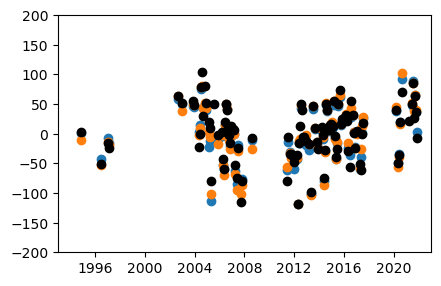

In [53]:
plt.figure(figsize=(14,6))
plt.subplots_adjust(left=0.07,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.15,
                    hspace=0.15)

idxf = 1
ax = plt.subplot(2,3,idxf)
plt.scatter(time_socat,ts_product_GStL_anom,label='product',c='tab:blue')
plt.scatter(time_socat,ts_product_re_GStL_anom,label='product_re',c='tab:orange')
plt.scatter(time_socat,ts_socat_GStL_anom,label='socat',c='k')
plt.ylim([-200,200])
plt.xlim([time_socat[0],np.datetime64('2023-01-01')])
ivalid = ~np.isnan(ts_product_GStL_anom*ts_socat_GStL_anom)
lm_i1 = sm.OLS(ts_socat_GStL_anom[ivalid],sm.add_constant(ts_product_GStL_anom[ivalid])).fit()
lm_i2= sm.OLS(ts_socat_GStL_anom[ivalid],sm.add_constant(ts_product_re_GStL_anom[ivalid])).fit()
ylim = np.array(ax.get_ylim())
ylim[0] = ylim[0] - 10
ylim[1] = ylim[1] + 10
ax.set_ylim(ylim)
plt.grid('on',alpha=0.5)
ax.text(time_socat[120],ylim[0]+0.93*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN) ='+ '%.2f' % lm_i1.rsquared,fontdict={'color':'tab:blue'})
ax.text(time_socat[120],ylim[0]+0.87*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN-recal) ='+ '%.2f' % lm_i2.rsquared,fontdict={'color':'tab:orange'})
ax.text(time_socat[3],ylim[1]-0.08*(ylim[1]-ylim[0]),chr(96+idxf) + '. GStL',fontdict={'weight':'bold'})

idxf = idxf + 1
ax = plt.subplot(2,3,idxf)
plt.scatter(time_socat,ts_product_SS_anom,label='product',c='tab:blue')
plt.scatter(time_socat,ts_product_re_SS_anom,label='product_re',c='tab:orange')
plt.scatter(time_socat,ts_socat_SS_anom,label='socat',c='k')
plt.ylim([-200,200])
plt.xlim([time_socat[0],np.datetime64('2023-01-01')])
ivalid = ~np.isnan(ts_product_SS_anom*ts_socat_SS_anom)
lm_i1 = sm.OLS(ts_socat_SS_anom[ivalid],sm.add_constant(ts_product_SS_anom[ivalid])).fit()
lm_i2= sm.OLS(ts_socat_SS_anom[ivalid],sm.add_constant(ts_product_re_SS_anom[ivalid])).fit()
ylim = np.array(ax.get_ylim())
ylim[0] = ylim[0] - 10
ylim[1] = ylim[1] + 10
ax.set_ylim(ylim)
plt.grid('on',alpha=0.5)
ax.text(time_socat[120],ylim[0]+0.93*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN) ='+ '%.2f' % lm_i1.rsquared,fontdict={'color':'tab:blue'})
ax.text(time_socat[120],ylim[0]+0.87*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN-recal) ='+ '%.2f' % lm_i2.rsquared,fontdict={'color':'tab:orange'})
ax.text(time_socat[3],ylim[1]-0.08*(ylim[1]-ylim[0]),chr(96+idxf) + '. SS',fontdict={'weight':'bold'})

idxf = idxf + 1
ax = plt.subplot(2,3,idxf)
plt.scatter(time_socat,ts_product_GoMe_anom,label='product',c='tab:blue')
plt.scatter(time_socat,ts_product_re_GoMe_anom,label='product_re',c='tab:orange')
plt.scatter(time_socat,ts_socat_GoMe_anom,label='socat',c='k')
plt.ylim([-200,200])
plt.xlim([time_socat[0],np.datetime64('2023-01-01')])
ivalid = ~np.isnan(ts_product_GoMe_anom*ts_socat_GoMe_anom)
lm_i1 = sm.OLS(ts_socat_GoMe_anom[ivalid],sm.add_constant(ts_product_GoMe_anom[ivalid])).fit()
lm_i2= sm.OLS(ts_socat_GoMe_anom[ivalid],sm.add_constant(ts_product_re_GoMe_anom[ivalid])).fit()
ylim = np.array(ax.get_ylim())
ylim[0] = ylim[0] - 10
ylim[1] = ylim[1] + 10
ax.set_ylim(ylim)
plt.grid('on',alpha=0.5)
ax.text(time_socat[120],ylim[0]+0.93*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN) ='+ '%.2f' % lm_i1.rsquared,fontdict={'color':'tab:blue'})
ax.text(time_socat[120],ylim[0]+0.87*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN-recal) ='+ '%.2f' % lm_i2.rsquared,fontdict={'color':'tab:orange'})
ax.text(time_socat[3],ylim[1]-0.08*(ylim[1]-ylim[0]),chr(96+idxf) + '. GoMe',fontdict={'weight':'bold'})

idxf = idxf + 1
ax = plt.subplot(2,3,idxf)
plt.scatter(time_socat,ts_product_MAB_anom,label='product',c='tab:blue')
plt.scatter(time_socat,ts_product_re_MAB_anom,label='product_re',c='tab:orange')
plt.scatter(time_socat,ts_socat_MAB_anom,label='socat',c='k')
plt.ylim([-200,200])
plt.xlim([time_socat[0],np.datetime64('2023-01-01')])
ivalid = ~np.isnan(ts_product_MAB_anom*ts_socat_MAB_anom)
lm_i1 = sm.OLS(ts_socat_MAB_anom[ivalid],sm.add_constant(ts_product_MAB_anom[ivalid])).fit()
lm_i2= sm.OLS(ts_socat_MAB_anom[ivalid],sm.add_constant(ts_product_re_MAB_anom[ivalid])).fit()
ylim = np.array(ax.get_ylim())
ylim[0] = ylim[0] - 10
ylim[1] = ylim[1] + 10
ax.set_ylim(ylim)
plt.grid('on',alpha=0.5)
ax.text(time_socat[120],ylim[0]+0.93*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN) ='+ '%.2f' % lm_i1.rsquared,fontdict={'color':'tab:blue'})
ax.text(time_socat[120],ylim[0]+0.87*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN-recal) ='+ '%.2f' % lm_i2.rsquared,fontdict={'color':'tab:orange'})
ax.text(time_socat[3],ylim[1]-0.08*(ylim[1]-ylim[0]),chr(96+idxf) + '. MAB',fontdict={'weight':'bold'})

idxf = idxf + 1
ax = plt.subplot(2,3,idxf)
p1 = plt.scatter(time_socat,ts_product_SAB_anom,label='product',c='tab:blue')
p2 = plt.scatter(time_socat,ts_product_re_SAB_anom,label='product_re',c='tab:orange')
p3 = plt.scatter(time_socat,ts_socat_SAB_anom,label='socat',c='k')
plt.ylim([-200,200])
plt.xlim([time_socat[0],np.datetime64('2023-01-01')])
ivalid = ~np.isnan(ts_product_SAB_anom*ts_socat_SAB_anom)
lm_i1 = sm.OLS(ts_socat_SAB_anom[ivalid],sm.add_constant(ts_product_SAB_anom[ivalid])).fit()
lm_i2= sm.OLS(ts_socat_SAB_anom[ivalid],sm.add_constant(ts_product_re_SAB_anom[ivalid])).fit()
ylim = np.array(ax.get_ylim())
ylim[0] = ylim[0] - 10
ylim[1] = ylim[1] + 10
ax.set_ylim(ylim)
plt.grid('on',alpha=0.5)
ax.text(time_socat[120],ylim[0]+0.93*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN) ='+ '%.2f' % lm_i1.rsquared,fontdict={'color':'tab:blue'})
ax.text(time_socat[120],ylim[0]+0.87*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN-recal) ='+ '%.2f' % lm_i2.rsquared,fontdict={'color':'tab:orange'})
ax.text(time_socat[3],ylim[1]-0.08*(ylim[1]-ylim[0]),chr(96+idxf) + '. SAB',fontdict={'weight':'bold'})

idxf = idxf + 1
ax = plt.subplot(2,3,idxf)
plt.scatter(time_socat,ts_product_GoMx_anom,label='product',c='tab:blue')
plt.scatter(time_socat,ts_product_re_GoMx_anom,label='product_re',c='tab:orange')
plt.scatter(time_socat,ts_socat_GoMx_anom,label='socat',c='k')
plt.ylim([-200,200])
plt.xlim([time_socat[0],np.datetime64('2023-01-01')])
ivalid = ~np.isnan(ts_product_GoMx_anom*ts_socat_GoMx_anom)
lm_i1 = sm.OLS(ts_socat_GoMx_anom[ivalid],sm.add_constant(ts_product_GoMx_anom[ivalid])).fit()
lm_i2= sm.OLS(ts_socat_GoMx_anom[ivalid],sm.add_constant(ts_product_re_GoMx_anom[ivalid])).fit()
ylim = np.array(ax.get_ylim())
ylim[0] = ylim[0] - 10
ylim[1] = ylim[1] + 10
ax.set_ylim(ylim)
plt.grid('on',alpha=0.5)
ax.text(time_socat[120],ylim[0]+0.93*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN) ='+ '%.2f' % lm_i1.rsquared,fontdict={'color':'tab:blue'})
ax.text(time_socat[120],ylim[0]+0.87*(ylim[1]-ylim[0]),'R$^2$ (SOCAT & SOM-FNN-recal) ='+ '%.2f' % lm_i2.rsquared,fontdict={'color':'tab:orange'})
ax.text(time_socat[3],ylim[1]-0.08*(ylim[1]-ylim[0]),chr(96+idxf) + '. GoMx',fontdict={'weight':'bold'})

plt.tight_layout()
# plt.savefig('figs/SI01_07.jpg',dpi=600,)
plt.show()
# In[ ]:

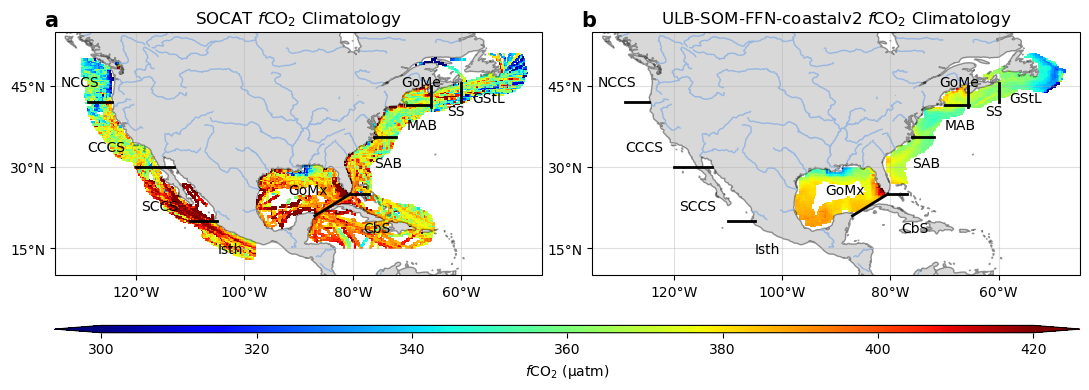

In [54]:
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))

fig = plt.figure(figsize=(11,4))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1,2),
                axes_pad=(0.5,0.3),
                cbar_location='bottom',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='1.5%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 20), crs=projection)
    ax.set_yticks(np.arange(15,66, 15), crs=projection)
    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-135,-45])
    ax.set_ylim([10,55])

    # boundary
    ax.plot([-80.5,-87],[25,21],c='k',linewidth=2) # GoMx & CbS
    ax.plot([-80.5,-77],[25,25],c='k',linewidth=2) # CbS & SAB
    ax.plot([-76,-72],[35.5,35.5],c='k',linewidth=2) # SAB & MAB
    ax.plot([-70,-65.5],[41.5,41.5],c='k',linewidth=2) # MAB & SS
    ax.plot([-65.6,-65.6],[41,45],c='k',linewidth=2) # SS & GoMe
    ax.plot([-60,-60],[42,45.5],c='k',linewidth=2) # SS & GStL

    ax.plot([-124.5,-128.9],[42,42],c='k',linewidth=2) # NCCS & CCCS
    ax.plot([-120,-113],[30,30],c='k',linewidth=2) # CCCS & SCCS
    ax.plot([-110,-105],[20,20],c='k',linewidth=2) # SCCS & Isth
    # names
    ax.text(-58,42,'GStL') 
    ax.text(-62.5,39.5,'SS') 
    ax.text(-71,45,'GoMe') 
    ax.text(-70,37,'MAB') 
    ax.text(-76,30,'SAB') 
    ax.text(-92,25,'GoMx') 
    ax.text(-78,18,'CbS') 

    ax.text(-134,45,'NCCS') 
    ax.text(-129,33,'CCCS') 
    ax.text(-119,22,'SCCS') 
    ax.text(-105,14,'Isth') 

    if i == 0:
        p0 = ax.pcolor(lon_socat,lat_socat,np.nanmean(fco2_socat_clim*mask['mask_NAC'][:12],axis=0), transform=projection,cmap='jet',clim=[300,420])
        ax.text(-137,56,'a',fontdict={'weight':'bold','size':15})
        ax.set_title('SOCAT ${f}$CO$_2$ Climatology')
    if i == 1:
        p1 = ax.pcolor(lon_socat,lat_socat,np.nanmean(fco2_product_calib*mask['mask_NAC'],axis=0), transform=projection,cmap='jet',clim=[300,420])
        ax.text(-137,56,'b',fontdict={'weight':'bold','size':15})
        ax.set_title('ULB-SOM-FFN-coastalv2 ${f}$CO$_2$ Climatology')
    # if i == 2:
    #     p2 = ax.pcolor(lon_socat,lat_socat,np.nanmean(fco2_product_calib*mask_NAC,axis=0), transform=projection,cmap='jet',clim=[300,420])
cb1 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='${f}$CO$_2$ (µatm)')
plt.tight_layout()
# plt.savefig('figs/Figure_fco2_clim.jpg',dpi=600,)
plt.show()

In [59]:
pco2_RFER = fco2_product*(1.00436 - 4.669 * 10**-5 * sst_oisst_3d)
pco2_RRERLR = fco2_product_calib*(1.00436 - 4.669 * 10**-5 * sst_oisst_3d)

In [63]:
x = fco2_product_calib * idx_out_train
y = fco2_socat * idx_out_train
ivalid = ~np.isnan(x*y)
lm_i = sm.OLS(y[ivalid], sm.add_constant(x[ivalid])).fit()
print(lm_i.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                 1.733e+05
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        10:18:48   Log-Likelihood:            -1.5145e+05
No. Observations:               35184   AIC:                         3.029e+05
Df Residuals:                   35182   BIC:                         3.029e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4113      0.885     11.767      0.0

In [66]:
x = fco2_product_calib * idx_out_test
y = fco2_socat * idx_out_test
ivalid = ~np.isnan(x*y)
lm_i = sm.OLS(y[ivalid], sm.add_constant(x[ivalid])).fit()
print(lm_i.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                 4.624e+04
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        10:18:51   Log-Likelihood:                -37604.
No. Observations:                8799   AIC:                         7.521e+04
Df Residuals:                    8797   BIC:                         7.523e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.3178      1.690      9.062      0.0

In [68]:
x = fco2_product_calib * idx_out_validation
y = fco2_socat * idx_out_validation
ivalid = ~np.isnan(x*y)
lm_i = sm.OLS(y[ivalid], sm.add_constant(x[ivalid])).fit()
print(lm_i.summary())

plt.scatter(x,y)
plt.plot([200,500],[200,500])

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
idx_temp = np.full_like(idx_out_train_4d,np.nan)
idx_temp[11:13,:] = 1.0
idx_temp = idx_temp.reshape(idx_out_train.shape)
idx_temp = np.float64(~np.isnan(idx_temp * fco2_socat * fco2_product_calib))
idx_temp[idx_temp<0.5] = np.nan

In [ ]:
idxlon = (lon_socat>=-100) & (lon_socat<=-40)
idxlat = (lat_socat>=15) & (lat_socat<=55)
lon_NAACOM = lon_socat[idxlon]
lat_NAACOM = lat_socat[idxlat]
fco2_socat_NACCOM = fco2_socat[:,idxlat,:][:,:,idxlon]
fco2_product_NACCOM = fco2_product_calib[:,idxlat,:][:,:,idxlon]
pco2_product_NACCOM = pco2_RRERLR[:,idxlat,:][:,:,idxlon]
idx_train = idx_out_train[:,idxlat,:][:,:,idxlon]
idx_test = idx_out_test[:,idxlat,:][:,:,idxlon]
idx_validation = idx_temp[:,idxlat,:][:,:,idxlon]

In [ ]:
ds = xr.Dataset(
    data_vars=dict(
        # fco2_product_re =(["time", "lat", "lon"], fco2_product_calib),
        fco2_socat =(["time", "lat", "lon"], fco2_socat_NACCOM,{'units':'µatm','description':'Fugacity of carbon dioxide (fCO2) sourced from the Surface Ocean CO2 Atlas (SOCAT) database'}),
        fco2_product =(["time", "lat", "lon"], fco2_product_NACCOM,{'units':'µatm','description':'Reconstructed fugacity of carbon dioxide (fCO2)'}),
        pco2_product =(["time", "lat", "lon"], pco2_product_NACCOM,{'units':'µatm','description':'Reconstructed partial pressure of carbon dioxide (pCO2), which is converted from the fco2_product with SST from OISST v2.1'}),
        idx_train =(["time", "lat", "lon"], idx_train, {'description':'Index denoting the fCO2 data points used for model training, where a value of 1 indicates the data point was utilized for training, and NaN represent data points that were not included in the training set'}),
        idx_test =(["time", "lat", "lon"], idx_test,{'description':'Index denoting the fCO2 data points used for model development test, where a value of 1 indicates the data point was utilized for test, and NaN represent data points that were not included in the test set'}),
        idx_validation =(["time", "lat", "lon"], idx_validation, {'description':'Index denoting the fCO2 data points used for model independent validation (2004-2005), where a value of 1 indicates the data point was utilized for test, and NaN represent data points that were not included in the test set'}),
    ),
    coords=dict(
        time=(["time"], time_socat,{'longname':'time'}),
        lat=(["lat"], lat_NAACOM ,{'longname':'latitude'}),
        lon=(["lon"], lon_NAACOM ,{'longname':'longitude'}),
    ),
    attrs=dict(description="Hybrid-NACOM-pCO2, where the fugacity of carbon dioxide (fCO2) is derived directly from the SOCAT fCO2 observations, and the partial pressure of carbon dioxide (pCO2) is subsequently calculated from the fCO2 using the sea surface temperature (SST) data from the OISST (Optimal Interpolation Sea Surface Temperature) product."),
)
ds.to_netcdf('/Volumes/Crucial_4T/carbon/Hybrid-NAC-pCO2/Hybrid-NAC-pCO2_v13.nc')

In [ ]:
ds = xr.Dataset(
    data_vars=dict(
        # fco2_product_re =(["time", "lat", "lon"], fco2_product_calib),
        fco2_socat =(["time", "lat", "lon"], fco2_socat,{'units':'µatm','description':'Fugacity of carbon dioxide (fCO2) sourced from the Surface Ocean CO2 Atlas (SOCAT) database'}),
        fco2_product =(["time", "lat", "lon"], fco2_product_calib,{'units':'µatm','description':'Reconstructed fugacity of carbon dioxide (fCO2)'}),
        pco2_product =(["time", "lat", "lon"], pco2_RRERLR,{'units':'µatm','description':'Reconstructed partial pressure of carbon dioxide (pCO2), which is converted from the fco2_product with SST from OISST v2.1'}),
        idx_train =(["time", "lat", "lon"], idx_out_train, {'description':'Index denoting the fCO2 data points used for model training, where a value of 1 indicates the data point was utilized for training, and NaN represent data points that were not included in the training set'}),
        idx_test =(["time", "lat", "lon"], idx_out_test,{'description':'Index denoting the fCO2 data points used for model development test, where a value of 1 indicates the data point was utilized for test, and NaN represent data points that were not included in the test set'}),
        idx_validation =(["time", "lat", "lon"], idx_out_validation, {'description':'Index denoting the fCO2 data points used for model independent validation (2004-2005), where a value of 1 indicates the data point was utilized for test, and NaN represent data points that were not included in the test set'}),
    ),
    coords=dict(
        time=(["time"], time_socat,{'longname':'time'}),
        lat=(["lat"], lat_socat ,{'longname':'latitude'}),
        lon=(["lon"], lon_socat ,{'longname':'longitude'}),
    ),
    attrs=dict(description="Hybrid-NACOM-pCO2, where the fugacity of carbon dioxide (fCO2) is derived directly from the SOCAT fCO2 observations, and the partial pressure of carbon dioxide (pCO2) is subsequently calculated from the fCO2 using the sea surface temperature (SST) data from the OISST (Optimal Interpolation Sea Surface Temperature) product."),
)
ds.to_netcdf('/Volumes/Crucial_4T/carbon/Hybrid-NAC-pCO2/Hybrid-NAC-pCO2_v2.nc')